# Final removal - remove all non common popoolation - baypass rows

In [1]:
import pandas as pd

In [ ]:
# Read the CSV files
baypass_df = pd.read_csv('../../../data/plots/baypass/Manhattan_plot_Sparus_Baypass_dataset.csv')
popoolation_df = pd.read_csv('../../../data/plots/popoolation/Manhattan_plot_Sp_aurata_Popoolation_dataset.csv')

In [23]:
BayPass_sparus_result=pd.read_csv("../../../data/plots/baypass/merged_baypass_results.csv", sep=",")

In [24]:
BayPass_sparus_result

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval),delog_pval,log10(1/pval)_BH,chromosome,pos
0,1,0.933919,0.035384,16.262752,5.677435,5.946988,2.684962,0.002066,1.053737,LR537121,24
1,2,0.993695,0.006925,18.139724,6.099700,8.840554,1.513754,0.030637,0.646328,LR537121,45
2,3,0.019453,0.012698,17.202001,5.951677,7.753486,1.877920,0.013246,0.777230,LR537121,51
3,4,0.008956,0.007391,17.682488,6.095531,7.275984,2.063166,0.008646,0.841229,LR537121,55
4,5,0.036887,0.020909,16.569256,5.872940,6.113623,2.596923,0.002530,1.019667,LR537121,63
...,...,...,...,...,...,...,...,...,...,...,...
5300851,174391,0.909310,0.051941,23.034086,6.128364,37.487582,1.689444,0.020444,0.643503,LR537144,22260474
5300852,174392,0.016705,0.013169,18.412503,6.009074,11.747053,0.821064,0.150986,0.292852,LR537144,22260486
5300853,174393,0.986422,0.014618,18.294364,6.077272,10.154980,1.158313,0.069452,0.437870,LR537144,22260505
5300854,174394,0.017082,0.012219,17.636279,6.078215,8.288052,1.689688,0.020432,0.643503,LR537144,22260506


In [13]:
baypass_df

,CHR,BP,P,SNP,i,colors
0,LR537121,24,1.053737,1,0,1
1,LR537121,45,0.646328,2,1,1
2,LR537121,51,0.777230,3,2,1
3,LR537121,55,0.841229,4,3,1
4,LR537121,63,1.019667,5,4,1
...,...,...,...,...,...,...
5300851,LR537144,22260474,0.643503,174391,5300851,0
5300852,LR537144,22260486,0.292852,174392,5300852,0
5300853,LR537144,22260505,0.437870,174393,5300853,0
5300854,LR537144,22260506,0.643503,174394,5300854,0


In [14]:
popoolation_df

,Unnamed: 0,CHR,BP,P_fet,i,colors
0,0,21,24,0.576,0,1
1,1,21,45,1.414,1,1
2,2,21,51,1.067,2,1
3,3,21,55,1.398,3,1
4,4,21,63,0.340,4,1
...,...,...,...,...,...,...
5300770,5300770,44,22260474,1.887,5300770,0
5300771,5300771,44,22260486,0.423,5300771,0
5300772,5300772,44,22260505,0.044,5300772,0
5300773,5300773,44,22260506,0.143,5300773,0


In [18]:
import pandas as pd
from typing import Tuple, Dict, List
import logging

def filter_genomic_datasets(
    baypass_df: pd.DataFrame,
    popoolation_df: pd.DataFrame,
    verbose: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Filter and compare two genomic datasets (Baypass and Popoolation) to find common positions
    within corresponding chromosomes.
    
    Args:
        baypass_df (pd.DataFrame): Baypass dataset with 'CHR' and 'BP' columns
        popoolation_df (pd.DataFrame): Popoolation dataset with 'CHR' and 'BP' columns
        verbose (bool): Whether to print detailed statistics (default: True)
    
    Returns:
        Tuple containing:
        - Filtered Baypass DataFrame
        - Filtered Popoolation DataFrame
        - Dictionary with summary statistics
    """
    # Input validation
    required_columns = {'CHR', 'BP'}
    if not all(col in baypass_df.columns for col in required_columns):
        raise ValueError("Baypass DataFrame missing required columns (CHR, BP)")
    if not all(col in popoolation_df.columns for col in required_columns):
        raise ValueError("Popoolation DataFrame missing required columns (CHR, BP)")

    # Split dataframes by chromosome
    baypass_by_chr = dict(tuple(baypass_df.groupby('CHR')))
    popoolation_by_chr = dict(tuple(popoolation_df.groupby('CHR')))

    # Create mapping between chromosome formats (LR537121 -> 21)
    chr_mapping = {chr_id: int(chr_id.replace('LR5371', '')) 
                  for chr_id in baypass_by_chr.keys()}

    filtered_baypass: List[pd.DataFrame] = []
    filtered_popoolation: List[pd.DataFrame] = []
    statistics = {
        'per_chromosome': [],
        'totals': {}
    }

    if verbose:
        print("\nDetailed Statistics per Chromosome:")
        print("-" * 80)
        print(f"{'Baypass Chr':<12} {'Pop Chr':<8} {'Baypass Rows':<12} "
              f"{'Pop Rows':<12} {'Kept':<8} {'Removed':<8} {'% Kept':<8}")
        print("-" * 80)

    total_original_baypass = 0
    total_original_pop = 0
    total_kept = 0

    # Process each chromosome
    for bay_chr, bay_data in baypass_by_chr.items():
        pop_chr = chr_mapping[bay_chr]  # Get corresponding popoolation chromosome number
        
        # Skip if chromosome not in popoolation data
        if pop_chr not in popoolation_by_chr:
            chr_stats = {
                'baypass_chr': bay_chr,
                'pop_chr': pop_chr,
                'original_baypass': len(bay_data),
                'original_pop': 0,
                'kept': 0,
                'removed': len(bay_data),
                'percent_kept': 0
            }
            statistics['per_chromosome'].append(chr_stats)
            
            if verbose:
                print(f"{bay_chr:<12} {pop_chr:<8} {len(bay_data):<12} "
                      f"{'N/A':<12} {'N/A':<8} {'N/A':<8} {'N/A':<8}")
            continue
        
        pop_data = popoolation_by_chr[pop_chr]
        
        # Find common positions
        common_positions = set(bay_data['BP']) & set(pop_data['BP'])
        
        # Filter dataframes
        bay_filtered = bay_data[bay_data['BP'].isin(common_positions)]
        pop_filtered = pop_data[pop_data['BP'].isin(common_positions)]
        
        # Add to results
        filtered_baypass.append(bay_filtered)
        filtered_popoolation.append(pop_filtered)
        
        # Calculate statistics
        original_bay = len(bay_data)
        original_pop = len(pop_data)
        kept = len(common_positions)
        removed = original_bay - kept
        percent_kept = (kept / original_bay * 100) if original_bay > 0 else 0
        
        # Update totals
        total_original_baypass += original_bay
        total_original_pop += original_pop
        total_kept += kept
        
        # Store chromosome statistics
        chr_stats = {
            'baypass_chr': bay_chr,
            'pop_chr': pop_chr,
            'original_baypass': original_bay,
            'original_pop': original_pop,
            'kept': kept,
            'removed': removed,
            'percent_kept': percent_kept
        }
        statistics['per_chromosome'].append(chr_stats)
        
        if verbose:
            print(f"{bay_chr:<12} {pop_chr:<8} {original_bay:<12} "
                  f"{original_pop:<12} {kept:<8} {removed:<8} {percent_kept:>6.1f}%")

    # Calculate and store totals
    total_removed = total_original_baypass - total_kept
    total_percent_kept = (total_kept / total_original_baypass * 100) if total_original_baypass > 0 else 0
    
    statistics['totals'] = {
        'total_original_baypass': total_original_baypass,
        'total_original_pop': total_original_pop,
        'total_kept': total_kept,
        'total_removed': total_removed,
        'total_percent_kept': total_percent_kept
    }

    if verbose:
        print("-" * 80)
        print(f"{'TOTAL':<12} {'':<8} {total_original_baypass:<12} "
              f"{total_original_pop:<12} {total_kept:<8} {total_removed:<8} "
              f"{total_percent_kept:>6.1f}%")

    # Combine filtered data
    filtered_baypass_df = pd.concat(filtered_baypass)
    filtered_popoolation_df = pd.concat(filtered_popoolation)

    # Reset indices
    filtered_baypass_df.reset_index(drop=True, inplace=True)
    filtered_popoolation_df.reset_index(drop=True, inplace=True)

    if verbose:
        print(f"\nFinal filtered dataframes shape:")
        print(f"Baypass: {filtered_baypass_df.shape}")
        print(f"Popoolation: {filtered_popoolation_df.shape}")

    return filtered_baypass_df, filtered_popoolation_df, statistics

# Filter the datasets
filtered_baypass, filtered_popoolation, stats = filter_genomic_datasets(
    baypass_df,
    popoolation_df,
    verbose=True
)


Detailed Statistics per Chromosome:
--------------------------------------------------------------------------------
Baypass Chr  Pop Chr  Baypass Rows Pop Rows     Kept     Removed  % Kept  
--------------------------------------------------------------------------------
LR537121     21       258596       258596       257740   856        99.7%
LR537122     22       228223       228223       227528   695        99.7%
LR537123     23       236766       236766       236035   731        99.7%
LR537124     24       248369       248318       247501   868        99.7%
LR537125     25       208685       208685       207982   703        99.7%
LR537126     26       227765       227750       226952   813        99.6%
LR537127     27       217436       217434       216722   714        99.7%
LR537128     28       211632       211632       210929   703        99.7%
LR537129     29       223920       223920       223205   715        99.7%
LR537130     30       276258       276246       275419   839

In [20]:
import pandas as pd
from typing import Tuple, Dict, List
import logging

def filter_genomic_datasets(
    baypass_df: pd.DataFrame,
    popoolation_df: pd.DataFrame,
    verbose: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Filter and compare two genomic datasets (Baypass and Popoolation) to find common positions
    within corresponding chromosomes.
    
    Args:
        baypass_df (pd.DataFrame): Baypass dataset with 'CHR' and 'BP' columns
        popoolation_df (pd.DataFrame): Popoolation dataset with 'CHR' and 'BP' columns
        verbose (bool): Whether to print detailed statistics (default: True)
    
    Returns:
        Tuple containing:
        - Filtered Baypass DataFrame
        - Filtered Popoolation DataFrame
        - Dictionary with summary statistics
    """
    # Input validation
    required_columns = {'CHR', 'BP'}
    if not all(col in baypass_df.columns for col in required_columns):
        raise ValueError("Baypass DataFrame missing required columns (CHR, BP)")
    if not all(col in popoolation_df.columns for col in required_columns):
        raise ValueError("Popoolation DataFrame missing required columns (CHR, BP)")

    # Split dataframes by chromosome
    baypass_by_chr = dict(tuple(baypass_df.groupby('CHR')))
    popoolation_by_chr = dict(tuple(popoolation_df.groupby('CHR')))

    # Create mapping between chromosome formats (LR537121 -> 21)
    chr_mapping = {chr_id: int(chr_id.replace('LR5371', '')) 
                  for chr_id in baypass_by_chr.keys()}

    filtered_baypass: List[pd.DataFrame] = []
    filtered_popoolation: List[pd.DataFrame] = []
    statistics = {
        'per_chromosome': [],
        'totals': {}
    }

    if verbose:
        print("\nDetailed Statistics per Chromosome:")
        print("-" * 80)
        print(f"{'Baypass Chr':<12} {'Pop Chr':<8} {'Baypass Rows':<12} "
              f"{'Pop Rows':<12} {'Kept':<8} {'Removed':<8} {'% Kept':<8}")
        print("-" * 80)

    total_original_baypass = 0
    total_original_pop = 0
    total_kept = 0

    # Process each chromosome
    for bay_chr, bay_data in baypass_by_chr.items():
        pop_chr = chr_mapping[bay_chr]  # Get corresponding popoolation chromosome number
        
        # Skip if chromosome not in popoolation data
        if pop_chr not in popoolation_by_chr:
            chr_stats = {
                'baypass_chr': bay_chr,
                'pop_chr': pop_chr,
                'original_baypass': len(bay_data),
                'original_pop': 0,
                'kept': 0,
                'removed': len(bay_data),
                'percent_kept': 0
            }
            statistics['per_chromosome'].append(chr_stats)
            
            if verbose:
                print(f"{bay_chr:<12} {pop_chr:<8} {len(bay_data):<12} "
                      f"{'N/A':<12} {'N/A':<8} {'N/A':<8} {'N/A':<8}")
            continue
        
        pop_data = popoolation_by_chr[pop_chr]
        
        # Find common positions
        common_positions = set(bay_data['BP']) & set(pop_data['BP'])
        
        # Filter dataframes
        bay_filtered = bay_data[bay_data['BP'].isin(common_positions)]
        pop_filtered = pop_data[pop_data['BP'].isin(common_positions)]
        
        # Add to results
        filtered_baypass.append(bay_filtered)
        filtered_popoolation.append(pop_filtered)
        
        # Calculate statistics
        original_bay = len(bay_data)
        original_pop = len(pop_data)
        kept = len(common_positions)
        removed = original_bay - kept
        percent_kept = (kept / original_bay * 100) if original_bay > 0 else 0
        
        # Update totals
        total_original_baypass += original_bay
        total_original_pop += original_pop
        total_kept += kept
        
        # Store chromosome statistics
        chr_stats = {
            'baypass_chr': bay_chr,
            'pop_chr': pop_chr,
            'original_baypass': original_bay,
            'original_pop': original_pop,
            'kept': kept,
            'removed': removed,
            'percent_kept': percent_kept
        }
        statistics['per_chromosome'].append(chr_stats)
        
        if verbose:
            print(f"{bay_chr:<12} {pop_chr:<8} {original_bay:<12} "
                  f"{original_pop:<12} {kept:<8} {removed:<8} {percent_kept:>6.1f}%")

    # Calculate and store totals
    total_removed = total_original_baypass - total_kept
    total_percent_kept = (total_kept / total_original_baypass * 100) if total_original_baypass > 0 else 0
    
    statistics['totals'] = {
        'total_original_baypass': total_original_baypass,
        'total_original_pop': total_original_pop,
        'total_kept': total_kept,
        'total_removed': total_removed,
        'total_percent_kept': total_percent_kept
    }

    if verbose:
        print("-" * 80)
        print(f"{'TOTAL':<12} {'':<8} {total_original_baypass:<12} "
              f"{total_original_pop:<12} {total_kept:<8} {total_removed:<8} "
              f"{total_percent_kept:>6.1f}%")

    # Combine filtered data
    filtered_baypass_df = pd.concat(filtered_baypass)
    filtered_popoolation_df = pd.concat(filtered_popoolation)

    # Reset indices
    filtered_baypass_df.reset_index(drop=True, inplace=True)
    filtered_popoolation_df.reset_index(drop=True, inplace=True)

    if verbose:
        print(f"\nFinal filtered dataframes shape:")
        print(f"Baypass: {filtered_baypass_df.shape}")
        print(f"Popoolation: {filtered_popoolation_df.shape}")

    return filtered_baypass_df, filtered_popoolation_df, statistics


def save_filtered_and_removed_data(
    baypass_df: pd.DataFrame,
    popoolation_df: pd.DataFrame,
    baypass_path: str,
    popoolation_path: str,
    filtered_suffix: str = "_filtered",
    removed_suffix: str = "_removed"
) -> Dict[str, str]:
    """
    Save both filtered datasets and their removed rows to CSV files.
    
    Args:
        baypass_df (pd.DataFrame): Original Baypass dataset
        popoolation_df (pd.DataFrame): Original Popoolation dataset
        baypass_path (str): Original Baypass CSV file path
        popoolation_path (str): Original Popoolation CSV file path
        filtered_suffix (str): Suffix to add for filtered data files (default: "_filtered")
        removed_suffix (str): Suffix to add for removed data files (default: "_removed")
        
    Returns:
        Dict containing paths to all saved files
    """
    # Process the datasets
    filtered_baypass, filtered_popoolation, stats = filter_genomic_datasets(
        baypass_df, 
        popoolation_df, 
        verbose=False
    )
    
    # Function to generate output paths
    def get_output_paths(original_path: str, suffix: str) -> str:
        path_parts = original_path.rsplit('.', 1)
        return f"{path_parts[0]}{suffix}.{path_parts[1]}"
    
    # Generate output paths
    baypass_filtered_path = get_output_paths(baypass_path, filtered_suffix)
    popoolation_filtered_path = get_output_paths(popoolation_path, filtered_suffix)
    baypass_removed_path = get_output_paths(baypass_path, removed_suffix)
    popoolation_removed_path = get_output_paths(popoolation_path, removed_suffix)
    
    # Get removed rows for Baypass
    baypass_positions = set(filtered_baypass['BP'])
    baypass_removed = baypass_df[~baypass_df['BP'].isin(baypass_positions)]
    
    # Get removed rows for Popoolation
    popoolation_positions = set(filtered_popoolation['BP'])
    popoolation_removed = popoolation_df[~popoolation_df['BP'].isin(popoolation_positions)]
    
    # Save all datasets
    print(f"\nSaving filtered and removed datasets...")
    
    # Save filtered datasets
    filtered_baypass.to_csv(baypass_filtered_path, index=False)
    filtered_popoolation.to_csv(popoolation_filtered_path, index=False)
    
    # Save removed rows
    baypass_removed.to_csv(baypass_removed_path, index=False)
    popoolation_removed.to_csv(popoolation_removed_path, index=False)
    
    # Prepare summary of saved files
    saved_files = {
        'baypass_filtered': baypass_filtered_path,
        'popoolation_filtered': popoolation_filtered_path,
        'baypass_removed': baypass_removed_path,
        'popoolation_removed': popoolation_removed_path
    }
    
    # Print summary
    print("\nFiles saved:")
    print(f"Filtered Baypass data: {baypass_filtered_path}")
    print(f"Filtered Popoolation data: {popoolation_filtered_path}")
    print(f"Removed Baypass data: {baypass_removed_path}")
    print(f"Removed Popoolation data: {popoolation_removed_path}")
    
    # Print row counts
    print("\nRow counts:")
    print(f"Baypass - Filtered: {len(filtered_baypass)}, Removed: {len(baypass_removed)}")
    print(f"Popoolation - Filtered: {len(filtered_popoolation)}, Removed: {len(popoolation_removed)}")
    
    return saved_files


# Example usage:
if __name__ == "__main__":
    # File paths
    base_dir = '../../../data/plots'
    baypass_dir = f"{base_dir}/baypass"
    popoolation_dir = f"{base_dir}/popoolation"
    
    file_pairs = [
        # Regular Baypass vs Popoolation
        {
            'baypass': f"{baypass_dir}/Manhattan_plot_Sparus_Baypass_dataset.csv",
            'popoolation': f"{popoolation_dir}/Manhattan_plot_Sp_aurata_Popoolation_dataset.csv",
            'label': 'Standard'
        },
        # C2 Baypass vs Popoolation
        {
            'baypass': f"{baypass_dir}/C2_Manhattan_plot_Sparus_Baypass_dataset.csv",
            'popoolation': f"{popoolation_dir}/Manhattan_plot_Sp_aurata_Popoolation_dataset.csv",
            'label': 'C2'
        }
    ]
    
    # Process each pair of files
    for pair in file_pairs:
        print(f"\nProcessing {pair['label']} dataset pair...")
        print("-" * 80)
        
        # Read the CSV files
        baypass_df = pd.read_csv(pair['baypass'])
        popoolation_df = pd.read_csv(pair['popoolation'])
        
        # Filter and save the datasets
        saved_files = save_filtered_and_removed_data(
            baypass_df,
            popoolation_df,
            pair['baypass'],
            pair['popoolation']
        )
        
        print("-" * 80)


Processing Standard dataset pair...
--------------------------------------------------------------------------------

Saving filtered and removed datasets...

Files saved:
Filtered Baypass data: ../../../data/plots/baypass/Manhattan_plot_Sparus_Baypass_dataset_filtered.csv
Filtered Popoolation data: ../../../data/plots/popoolation/Manhattan_plot_Sp_aurata_Popoolation_dataset_filtered.csv
Removed Baypass data: ../../../data/plots/baypass/Manhattan_plot_Sparus_Baypass_dataset_removed.csv
Removed Popoolation data: ../../../data/plots/popoolation/Manhattan_plot_Sp_aurata_Popoolation_dataset_removed.csv

Row counts:
Baypass - Filtered: 5282884, Removed: 15357
Popoolation - Filtered: 5282884, Removed: 15379
--------------------------------------------------------------------------------

Processing C2 dataset pair...
--------------------------------------------------------------------------------

Saving filtered and removed datasets...

Files saved:
Filtered Baypass data: ../../../data/plo

In [21]:
import pandas as pd
from typing import Tuple, Dict, List
import logging

def filter_genomic_datasets(
    baypass_df: pd.DataFrame,
    popoolation_df: pd.DataFrame,
    verbose: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Filter and compare two genomic datasets (Baypass and Popoolation) to find common positions
    within corresponding chromosomes.
    
    Args:
        baypass_df (pd.DataFrame): Baypass dataset with 'CHR' and 'BP' columns
        popoolation_df (pd.DataFrame): Popoolation dataset with 'CHR' and 'BP' columns
        verbose (bool): Whether to print detailed statistics (default: True)
    
    Returns:
        Tuple containing:
        - Filtered Baypass DataFrame
        - Filtered Popoolation DataFrame
        - Dictionary with summary statistics
    """
    # Input validation
    required_columns = {'CHR', 'BP'}
    if not all(col in baypass_df.columns for col in required_columns):
        raise ValueError("Baypass DataFrame missing required columns (CHR, BP)")
    if not all(col in popoolation_df.columns for col in required_columns):
        raise ValueError("Popoolation DataFrame missing required columns (CHR, BP)")

    # Split dataframes by chromosome
    baypass_by_chr = dict(tuple(baypass_df.groupby('CHR')))
    popoolation_by_chr = dict(tuple(popoolation_df.groupby('CHR')))

    # Create mapping between chromosome formats (LR537121 -> 21)
    chr_mapping = {chr_id: int(chr_id.replace('LR5371', '')) 
                  for chr_id in baypass_by_chr.keys()}

    filtered_baypass: List[pd.DataFrame] = []
    filtered_popoolation: List[pd.DataFrame] = []
    statistics = {
        'per_chromosome': [],
        'totals': {}
    }

    if verbose:
        print("\nDetailed Statistics per Chromosome:")
        print("-" * 80)
        print(f"{'Baypass Chr':<12} {'Pop Chr':<8} {'Baypass Rows':<12} "
              f"{'Pop Rows':<12} {'Kept':<8} {'Removed':<8} {'% Kept':<8}")
        print("-" * 80)

    total_original_baypass = 0
    total_original_pop = 0
    total_kept = 0

    # Process each chromosome
    for bay_chr, bay_data in baypass_by_chr.items():
        pop_chr = chr_mapping[bay_chr]  # Get corresponding popoolation chromosome number
        
        # Skip if chromosome not in popoolation data
        if pop_chr not in popoolation_by_chr:
            chr_stats = {
                'baypass_chr': bay_chr,
                'pop_chr': pop_chr,
                'original_baypass': len(bay_data),
                'original_pop': 0,
                'kept': 0,
                'removed': len(bay_data),
                'percent_kept': 0
            }
            statistics['per_chromosome'].append(chr_stats)
            
            if verbose:
                print(f"{bay_chr:<12} {pop_chr:<8} {len(bay_data):<12} "
                      f"{'N/A':<12} {'N/A':<8} {'N/A':<8} {'N/A':<8}")
            continue
        
        pop_data = popoolation_by_chr[pop_chr]
        
        # Find common positions
        common_positions = set(bay_data['BP']) & set(pop_data['BP'])
        
        # Filter dataframes
        bay_filtered = bay_data[bay_data['BP'].isin(common_positions)]
        pop_filtered = pop_data[pop_data['BP'].isin(common_positions)]
        
        # Add to results
        filtered_baypass.append(bay_filtered)
        filtered_popoolation.append(pop_filtered)
        
        # Calculate statistics
        original_bay = len(bay_data)
        original_pop = len(pop_data)
        kept = len(common_positions)
        removed = original_bay - kept
        percent_kept = (kept / original_bay * 100) if original_bay > 0 else 0
        
        # Update totals
        total_original_baypass += original_bay
        total_original_pop += original_pop
        total_kept += kept
        
        # Store chromosome statistics
        chr_stats = {
            'baypass_chr': bay_chr,
            'pop_chr': pop_chr,
            'original_baypass': original_bay,
            'original_pop': original_pop,
            'kept': kept,
            'removed': removed,
            'percent_kept': percent_kept
        }
        statistics['per_chromosome'].append(chr_stats)
        
        if verbose:
            print(f"{bay_chr:<12} {pop_chr:<8} {original_bay:<12} "
                  f"{original_pop:<12} {kept:<8} {removed:<8} {percent_kept:>6.1f}%")

    # Calculate and store totals
    total_removed = total_original_baypass - total_kept
    total_percent_kept = (total_kept / total_original_baypass * 100) if total_original_baypass > 0 else 0
    
    statistics['totals'] = {
        'total_original_baypass': total_original_baypass,
        'total_original_pop': total_original_pop,
        'total_kept': total_kept,
        'total_removed': total_removed,
        'total_percent_kept': total_percent_kept
    }

    if verbose:
        print("-" * 80)
        print(f"{'TOTAL':<12} {'':<8} {total_original_baypass:<12} "
              f"{total_original_pop:<12} {total_kept:<8} {total_removed:<8} "
              f"{total_percent_kept:>6.1f}%")

    # Combine filtered data
    filtered_baypass_df = pd.concat(filtered_baypass)
    filtered_popoolation_df = pd.concat(filtered_popoolation)

    # Reset indices
    filtered_baypass_df.reset_index(drop=True, inplace=True)
    filtered_popoolation_df.reset_index(drop=True, inplace=True)

    if verbose:
        print(f"\nFinal filtered dataframes shape:")
        print(f"Baypass: {filtered_baypass_df.shape}")
        print(f"Popoolation: {filtered_popoolation_df.shape}")

    return filtered_baypass_df, filtered_popoolation_df, statistics


def save_filtered_and_removed_data(
    baypass_df: pd.DataFrame,
    popoolation_df: pd.DataFrame,
    baypass_path: str,
    popoolation_path: str,
    filtered_suffix: str = "_filtered",
    removed_suffix: str = "_removed"
) -> Dict[str, str]:
    """
    Save both filtered datasets and their removed rows to CSV files.
    Process data chromosome by chromosome for accurate tracking.
    
    Args:
        baypass_df (pd.DataFrame): Original Baypass dataset
        popoolation_df (pd.DataFrame): Original Popoolation dataset
        baypass_path (str): Original Baypass CSV file path
        popoolation_path (str): Original Popoolation CSV file path
        filtered_suffix (str): Suffix to add for filtered data files (default: "_filtered")
        removed_suffix (str): Suffix to add for removed data files (default: "_removed")
        
    Returns:
        Dict containing paths to all saved files
    """
    # Function to generate output paths
    def get_output_paths(original_path: str, suffix: str) -> str:
        path_parts = original_path.rsplit('.', 1)
        return f"{path_parts[0]}{suffix}.{path_parts[1]}"
    
    # Generate output paths
    baypass_filtered_path = get_output_paths(baypass_path, filtered_suffix)
    popoolation_filtered_path = get_output_paths(popoolation_path, filtered_suffix)
    baypass_removed_path = get_output_paths(baypass_path, removed_suffix)
    popoolation_removed_path = get_output_paths(popoolation_path, removed_suffix)
    
    # Split dataframes by chromosome
    baypass_by_chr = dict(tuple(baypass_df.groupby('CHR')))
    popoolation_by_chr = dict(tuple(popoolation_df.groupby('CHR')))
    
    # Create mapping between chromosome formats
    chr_mapping = {chr_id: int(chr_id.replace('LR5371', '')) 
                  for chr_id in baypass_by_chr.keys()}
    
    filtered_baypass = []
    filtered_popoolation = []
    removed_baypass = []
    removed_popoolation = []
    
    print("\nProcessing by chromosome:")
    print("-" * 100)
    print(f"{'Baypass Chr':<12} {'Pop Chr':<8} {'Original Bay':<12} {'Original Pop':<12} {'Filtered':<10} {'Removed Bay':<12} {'Removed Pop':<12}")
    print("-" * 100)
    
    total_original_bay = 0
    total_original_pop = 0
    total_filtered = 0
    total_removed_bay = 0
    total_removed_pop = 0
    
    # Process each chromosome
    for bay_chr, bay_data in baypass_by_chr.items():
        pop_chr = chr_mapping[bay_chr]
        
        if pop_chr not in popoolation_by_chr:
            print(f"{bay_chr:<12} {pop_chr:<8} {'N/A':<12} {'N/A':<12} {'N/A':<10} {'N/A':<12} {'N/A':<12}")
            continue
        
        pop_data = popoolation_by_chr[pop_chr]
        
        # Find common positions
        common_positions = set(bay_data['BP']) & set(pop_data['BP'])
        
        # Filter datasets
        bay_filtered = bay_data[bay_data['BP'].isin(common_positions)]
        pop_filtered = pop_data[pop_data['BP'].isin(common_positions)]
        
        # Get removed rows
        bay_removed = bay_data[~bay_data['BP'].isin(common_positions)]
        pop_removed = pop_data[~pop_data['BP'].isin(common_positions)]
        
        # Add to results
        filtered_baypass.append(bay_filtered)
        filtered_popoolation.append(pop_filtered)
        removed_baypass.append(bay_removed)
        removed_popoolation.append(pop_removed)
        
        # Update totals
        total_original_bay += len(bay_data)
        total_original_pop += len(pop_data)
        total_filtered += len(bay_filtered)
        total_removed_bay += len(bay_removed)
        total_removed_pop += len(pop_removed)
        
        # Print chromosome statistics
        print(f"{bay_chr:<12} {pop_chr:<8} {len(bay_data):<12} {len(pop_data):<12} "
              f"{len(bay_filtered):<10} {len(bay_removed):<12} {len(pop_removed):<12}")
    
    # Print totals
    print("-" * 100)
    print(f"{'TOTAL':<12} {'':<8} {total_original_bay:<12} {total_original_pop:<12} "
          f"{total_filtered:<10} {total_removed_bay:<12} {total_removed_pop:<12}")
    
    # Combine and save filtered datasets
    print("\nSaving datasets...")
    filtered_baypass_df = pd.concat(filtered_baypass)
    filtered_popoolation_df = pd.concat(filtered_popoolation)
    removed_baypass_df = pd.concat(removed_baypass)
    removed_popoolation_df = pd.concat(removed_popoolation)
    
    # Reset indices
    filtered_baypass_df.reset_index(drop=True, inplace=True)
    filtered_popoolation_df.reset_index(drop=True, inplace=True)
    removed_baypass_df.reset_index(drop=True, inplace=True)
    removed_popoolation_df.reset_index(drop=True, inplace=True)
    
    # Save all datasets
    filtered_baypass_df.to_csv(baypass_filtered_path, index=False)
    filtered_popoolation_df.to_csv(popoolation_filtered_path, index=False)
    removed_baypass_df.to_csv(baypass_removed_path, index=False)
    removed_popoolation_df.to_csv(popoolation_removed_path, index=False)
    
    # Prepare summary of saved files
    saved_files = {
        'baypass_filtered': baypass_filtered_path,
        'popoolation_filtered': popoolation_filtered_path,
        'baypass_removed': baypass_removed_path,
        'popoolation_removed': popoolation_removed_path
    }
    
    print("\nFiles saved:")
    for label, path in saved_files.items():
        print(f"{label}: {path}")
    
    return saved_files


# Example usage:
if __name__ == "__main__":
    # File paths
    base_dir = '../../../data/plots'
    baypass_dir = f"{base_dir}/baypass"
    popoolation_dir = f"{base_dir}/popoolation"
    
    file_pairs = [
        # Regular Baypass vs Popoolation
        {
            'baypass': f"{baypass_dir}/Manhattan_plot_Sparus_Baypass_dataset.csv",
            'popoolation': f"{popoolation_dir}/Manhattan_plot_Sp_aurata_Popoolation_dataset.csv",
            'label': 'Standard'
        },
        # C2 Baypass vs Popoolation
        {
            'baypass': f"{baypass_dir}/C2_Manhattan_plot_Sparus_Baypass_dataset.csv",
            'popoolation': f"{popoolation_dir}/Manhattan_plot_Sp_aurata_Popoolation_dataset.csv",
            'label': 'C2'
        }
    ]
    
    # Process each pair of files
    for pair in file_pairs:
        print(f"\nProcessing {pair['label']} dataset pair...")
        print("-" * 80)
        
        # Read the CSV files
        baypass_df = pd.read_csv(pair['baypass'])
        popoolation_df = pd.read_csv(pair['popoolation'])
        
        # Filter and save the datasets
        saved_files = save_filtered_and_removed_data(
            baypass_df,
            popoolation_df,
            pair['baypass'],
            pair['popoolation']
        )
        
        print("-" * 80)


Processing Standard dataset pair...
--------------------------------------------------------------------------------

Processing by chromosome:
----------------------------------------------------------------------------------------------------
Baypass Chr  Pop Chr  Original Bay Original Pop Filtered   Removed Bay  Removed Pop 
----------------------------------------------------------------------------------------------------
LR537121     21       258596       258596       257740     856          856         
LR537122     22       228223       228223       227528     695          695         
LR537123     23       236766       236766       236035     731          731         
LR537124     24       248369       248318       247501     868          817         
LR537125     25       208685       208685       207982     703          703         
LR537126     26       227765       227750       226952     813          798         
LR537127     27       217436       217434       216722    

In [22]:
import pandas as pd
import os

def verify_filtered_files(base_dir: str):
    """
    Verify the filtered files to ensure consistency between datasets.
    
    Args:
        base_dir (str): Base directory containing the plots folder
    """
    # Define paths
    baypass_dir = os.path.join(base_dir, 'data', 'plots', 'baypass')
    popoolation_dir = os.path.join(base_dir, 'data', 'plots', 'popoolation')
    
    # File pairs to verify
    file_pairs = [
        {
            'label': 'Standard dataset',
            'baypass': 'Manhattan_plot_Sparus_Baypass_dataset_filtered.csv',
            'popoolation': 'Manhattan_plot_Sp_aurata_Popoolation_dataset_filtered.csv'
        },
        {
            'label': 'C2 dataset',
            'baypass': 'C2_Manhattan_plot_Sparus_Baypass_dataset_filtered.csv',
            'popoolation': 'Manhattan_plot_Sp_aurata_Popoolation_dataset_filtered.csv'
        }
    ]
    
    for pair in file_pairs:
        print(f"\nVerifying {pair['label']}:")
        print("-" * 80)
        
        # Read filtered files
        baypass_path = os.path.join(baypass_dir, pair['baypass'])
        popoolation_path = os.path.join(popoolation_dir, pair['popoolation'])
        
        baypass_df = pd.read_csv(baypass_path)
        popoolation_df = pd.read_csv(popoolation_path)
        
        # Basic checks
        print(f"Row counts:")
        print(f"Baypass filtered: {len(baypass_df)}")
        print(f"Popoolation filtered: {len(popoolation_df)}")
        
        # Verify BP positions match
        baypass_positions = set(baypass_df['BP'])
        popoolation_positions = set(popoolation_df['BP'])
        
        positions_match = baypass_positions == popoolation_positions
        print(f"\nAll positions match: {positions_match}")
        
        if not positions_match:
            only_in_baypass = baypass_positions - popoolation_positions
            only_in_popoolation = popoolation_positions - baypass_positions
            print(f"Positions only in Baypass: {len(only_in_baypass)}")
            print(f"Positions only in Popoolation: {len(only_in_popoolation)}")
        
        # Check chromosome by chromosome
        print("\nChromosome-wise verification:")
        print(f"{'Chromosome':<12} {'Baypass Rows':<12} {'Pop Rows':<12} {'Positions Match':<15}")
        print("-" * 80)
        
        baypass_by_chr = dict(tuple(baypass_df.groupby('CHR')))
        popoolation_by_chr = dict(tuple(popoolation_df.groupby('CHR')))
        
        # Create mapping between chromosome formats
        chr_mapping = {chr_id: int(chr_id.replace('LR5371', '')) 
                      for chr_id in baypass_by_chr.keys()}
        
        for bay_chr, bay_data in baypass_by_chr.items():
            pop_chr = chr_mapping[bay_chr]
            if pop_chr not in popoolation_by_chr:
                print(f"{bay_chr:<12} {len(bay_data):<12} {'N/A':<12} {'N/A':<15}")
                continue
                
            pop_data = popoolation_by_chr[pop_chr]
            
            # Check if positions match for this chromosome
            bay_pos = set(bay_data['BP'])
            pop_pos = set(pop_data['BP'])
            pos_match = bay_pos == pop_pos
            
            print(f"{bay_chr:<12} {len(bay_data):<12} {len(pop_data):<12} {str(pos_match):<15}")
            
            if not pos_match:
                only_in_bay = bay_pos - pop_pos
                only_in_pop = pop_pos - bay_pos
                print(f"  Positions only in Baypass: {len(only_in_bay)}")
                print(f"  Positions only in Popoolation: {len(only_in_pop)}")

if __name__ == "__main__":
    # Adjust this path to match your directory structure
    base_dir = "../../.."
    verify_filtered_files(base_dir)


Verifying Standard dataset:
--------------------------------------------------------------------------------
Row counts:
Baypass filtered: 5282884
Popoolation filtered: 5282884

All positions match: True

Chromosome-wise verification:
Chromosome   Baypass Rows Pop Rows     Positions Match
--------------------------------------------------------------------------------
LR537121     257740       257740       True           
LR537122     227528       227528       True           
LR537123     236035       236035       True           
LR537124     247501       247501       True           
LR537125     207982       207982       True           
LR537126     226952       226952       True           
LR537127     216722       216722       True           
LR537128     210929       210929       True           
LR537129     223205       223205       True           
LR537130     275419       275419       True           
LR537131     227386       227386       True           
LR537132     219536    

## We will remove the same rows from the complete data files as well

In [1]:
import pandas as pd
BayPass_data = pd.read_csv("../../../data/plots/baypass/merged_baypass_results.csv", sep=",")
BayPass_data["chromosome"] = BayPass_data["chromosome"].str[6:].astype(int)
C2_data = pd.read_csv('../../../data/plots/baypass/C2_merged_baypass_results.csv')
C2_data["chromosome"] = C2_data["chromosome"].str[6:].astype(int)

In [2]:
# Load previously filtered data (to get valid positions)
baypass_filtered = pd.read_csv('../../../data/plots/baypass/Manhattan_plot_Sparus_Baypass_dataset_filtered.csv')
baypass_filtered["CHR"] = baypass_filtered["CHR"].str[6:].astype(int)

In [3]:
BayPass_data

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval),delog_pval,log10(1/pval)_BH,chromosome,pos
0,1,0.933919,0.035384,16.262752,5.677435,5.946988,2.684962,0.002066,1.053737,21,24
1,2,0.993695,0.006925,18.139724,6.099700,8.840554,1.513754,0.030637,0.646328,21,45
2,3,0.019453,0.012698,17.202001,5.951677,7.753486,1.877920,0.013246,0.777230,21,51
3,4,0.008956,0.007391,17.682488,6.095531,7.275984,2.063166,0.008646,0.841229,21,55
4,5,0.036887,0.020909,16.569256,5.872940,6.113623,2.596923,0.002530,1.019667,21,63
...,...,...,...,...,...,...,...,...,...,...,...
5300851,174391,0.909310,0.051941,23.034086,6.128364,37.487582,1.689444,0.020444,0.643503,44,22260474
5300852,174392,0.016705,0.013169,18.412503,6.009074,11.747053,0.821064,0.150986,0.292852,44,22260486
5300853,174393,0.986422,0.014618,18.294364,6.077272,10.154980,1.158313,0.069452,0.437870,44,22260505
5300854,174394,0.017082,0.012219,17.636279,6.078215,8.288052,1.689688,0.020432,0.643503,44,22260506


In [4]:
baypass_filtered

,CHR,BP,P,SNP,i,colors
0,21,24,1.053737,1,0,1
1,21,45,0.646328,2,1,1
2,21,51,0.777230,3,2,1
3,21,55,0.841229,4,3,1
4,21,63,1.019667,5,4,1
...,...,...,...,...,...,...
5282879,44,22260474,0.643503,174391,5300851,0
5282880,44,22260486,0.292852,174392,5300852,0
5282881,44,22260505,0.437870,174393,5300853,0
5282882,44,22260506,0.643503,174394,5300854,0


In [5]:
import pandas as pd

# Create a set of valid (chromosome, position) pairs
valid_positions = set(zip(baypass_filtered['CHR'].astype(int), baypass_filtered['BP'].astype(int)))

# Filter both datasets
BayPass_filtered = BayPass_data[BayPass_data.apply(lambda row: (int(row['chromosome']), int(row['pos'])) in valid_positions, axis=1)]
C2_filtered = C2_data[C2_data.apply(lambda row: (int(row['chromosome']), int(row['pos'])) in valid_positions, axis=1)]

# Save filtered data
BayPass_filtered.to_csv('../../../data/plots/baypass/merged_baypass_results_filtered.csv', index=False)
C2_filtered.to_csv('../../../data/plots/baypass/C2_merged_baypass_results_filtered.csv', index=False)

# Print summary
print(f"Original BayPass rows: {len(BayPass_data)}, Filtered: {len(BayPass_filtered)}")
print(f"Original C2 rows: {len(C2_data)}, Filtered: {len(C2_filtered)}")

Original BayPass rows: 5300856, Filtered: 5282884
Original C2 rows: 5300856, Filtered: 5282884


In [6]:
BayPass_data

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval),delog_pval,log10(1/pval)_BH,chromosome,pos
0,1,0.933919,0.035384,16.262752,5.677435,5.946988,2.684962,0.002066,1.053737,21,24
1,2,0.993695,0.006925,18.139724,6.099700,8.840554,1.513754,0.030637,0.646328,21,45
2,3,0.019453,0.012698,17.202001,5.951677,7.753486,1.877920,0.013246,0.777230,21,51
3,4,0.008956,0.007391,17.682488,6.095531,7.275984,2.063166,0.008646,0.841229,21,55
4,5,0.036887,0.020909,16.569256,5.872940,6.113623,2.596923,0.002530,1.019667,21,63
...,...,...,...,...,...,...,...,...,...,...,...
5300851,174391,0.909310,0.051941,23.034086,6.128364,37.487582,1.689444,0.020444,0.643503,44,22260474
5300852,174392,0.016705,0.013169,18.412503,6.009074,11.747053,0.821064,0.150986,0.292852,44,22260486
5300853,174393,0.986422,0.014618,18.294364,6.077272,10.154980,1.158313,0.069452,0.437870,44,22260505
5300854,174394,0.017082,0.012219,17.636279,6.078215,8.288052,1.689688,0.020432,0.643503,44,22260506


In [ ]:
# TODO - remove the rows for popoolation fst too - check sp manhattan popoolation, there might be multiple files before/after correction

In [7]:
import pandas as pd

In [8]:
Popoolation_fst=pd.read_csv(rf"../../../data/plots/popoolation/merged_Sparus_popoolation_results.csv", sep=",")

In [9]:
Popoolation_fst

,Fst,index1,1,0,FET_AVG_BHcor
0,0.009029,0,24,21,0.576
1,0.011142,1,45,21,1.414
2,0.007816,2,51,21,1.067
3,0.007468,3,55,21,1.398
4,0.006778,4,63,21,0.340
...,...,...,...,...,...
5300770,0.026319,174390,22260474,44,1.887
5300771,0.016732,174391,22260486,44,0.423
5300772,0.011063,174392,22260505,44,0.044
5300773,0.015679,174393,22260506,44,0.143


In [10]:
Popoolation_fst.rename(columns={'1':'pos','0':'CHR'},inplace=True)

In [11]:
# Load previously filtered data (to get valid positions)
baypass_filtered = pd.read_csv('../../../data/plots/baypass/Manhattan_plot_Sparus_Baypass_dataset_filtered.csv')
baypass_filtered["CHR"] = baypass_filtered["CHR"].str[6:].astype(int)

In [12]:
import pandas as pd

# Create a set of valid (chromosome, position) pairs
valid_positions = set(zip(baypass_filtered['CHR'].astype(int), baypass_filtered['BP'].astype(int)))

# Filter both datasets
Popoolation_fst_filtered = Popoolation_fst[Popoolation_fst.apply(lambda row: (int(row['CHR']), int(row['pos'])) in valid_positions, axis=1)]

# Save filtered data
Popoolation_fst_filtered.to_csv('../../../data/plots/popoolation/merged_Sparus_popoolation_results_filtered.csv', index=False)

# Print summary
print(f"Original Popoolation rows: {len(Popoolation_fst)}, Filtered: {len(Popoolation_fst_filtered)}")

Original Popoolation rows: 5300775, Filtered: 5282884


In [13]:
baypass_std = pd.read_csv('../../../data/plots/baypass/Manhattan_plot_Sparus_Baypass_dataset_filtered.csv')
baypass_c2 = pd.read_csv('../../../data/plots/baypass/C2_Manhattan_plot_Sparus_Baypass_dataset_filtered.csv')
popoolation = pd.read_csv('../../../data/plots/popoolation/Manhattan_plot_Sp_aurata_Popoolation_dataset_filtered.csv')
popoolation_fst = pd.read_csv('../../../data/plots/popoolation/merged_Sparus_popoolation_results_filtered.csv')

In [14]:
popoolation_fst

,Fst,index1,pos,CHR,FET_AVG_BHcor
0,0.009029,0,24,21,0.576
1,0.011142,1,45,21,1.414
2,0.007816,2,51,21,1.067
3,0.007468,3,55,21,1.398
4,0.006778,4,63,21,0.340
...,...,...,...,...,...
5282879,0.026319,174390,22260474,44,1.887
5282880,0.016732,174391,22260486,44,0.423
5282881,0.011063,174392,22260505,44,0.044
5282882,0.015679,174393,22260506,44,0.143


In [15]:
# streamline the chromosome columns to be integers
baypass_std["CHR"] = baypass_std["CHR"].str[6:].astype(int)
baypass_c2["CHR"] = baypass_c2["CHR"].str[6:].astype(int)

In [16]:
BayPass_filtered = pd.read_csv('../../../data/plots/baypass/merged_baypass_results_filtered.csv')
C2_filtered = pd.read_csv('../../../data/plots/baypass/C2_merged_baypass_results_filtered.csv')

In [17]:
BayPass_filtered

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval),delog_pval,log10(1/pval)_BH,chromosome,pos
0,1,0.933919,0.035384,16.262752,5.677435,5.946988,2.684962,0.002066,1.053737,21,24
1,2,0.993695,0.006925,18.139724,6.099700,8.840554,1.513754,0.030637,0.646328,21,45
2,3,0.019453,0.012698,17.202001,5.951677,7.753486,1.877920,0.013246,0.777230,21,51
3,4,0.008956,0.007391,17.682488,6.095531,7.275984,2.063166,0.008646,0.841229,21,55
4,5,0.036887,0.020909,16.569256,5.872940,6.113623,2.596923,0.002530,1.019667,21,63
...,...,...,...,...,...,...,...,...,...,...,...
5282879,174391,0.909310,0.051941,23.034086,6.128364,37.487582,1.689444,0.020444,0.643503,44,22260474
5282880,174392,0.016705,0.013169,18.412503,6.009074,11.747053,0.821064,0.150986,0.292852,44,22260486
5282881,174393,0.986422,0.014618,18.294364,6.077272,10.154980,1.158313,0.069452,0.437870,44,22260505
5282882,174394,0.017082,0.012219,17.636279,6.078215,8.288052,1.689688,0.020432,0.643503,44,22260506


In [22]:
C2_filtered

,CONTRAST,MRK,M_C2,SD_C2,C2_std,log10(1/pval),delog_pval,log10(1/pval)_BH,chromosome,pos
0,1,1,0.740179,1.049696,0.483858,0.312757,0.486680,0.060084,21,24
1,1,2,0.637535,0.915446,0.008715,0.033567,0.925620,0.005346,21,45
2,1,3,0.673391,0.968527,0.059778,0.093209,0.806847,0.015436,21,51
3,1,4,0.661905,0.931297,0.019919,0.051702,0.887765,0.008113,21,55
4,1,5,0.665275,0.962476,0.148012,0.154627,0.700443,0.026425,21,63
...,...,...,...,...,...,...,...,...,...,...
5282879,1,174391,1.846816,1.712734,4.573860,1.488607,0.032463,0.347022,44,22260474
5282880,1,174392,0.732208,1.018430,0.494358,0.316962,0.481990,0.058563,44,22260486
5282881,1,174393,0.889039,1.201577,0.916128,0.470450,0.338494,0.092500,44,22260505
5282882,1,174394,1.069129,1.411495,1.389877,0.622647,0.238426,0.127949,44,22260506


In [18]:
merged_df = pd.DataFrame()
merged_df['CHR'] = BayPass_filtered['chromosome'] # or C2['chromosome']
merged_df['POS'] = BayPass_filtered['pos'] # or C2['pos']
merged_df['MRK'] = BayPass_filtered['MRK'] # or C2['MRK']
merged_df['XtXst'] = BayPass_filtered['XtXst']
merged_df['C2_std'] = C2_filtered['C2_std']
merged_df['XTX_log10(1/pval)'] = BayPass_filtered['log10(1/pval)_BH']
merged_df['C2_log10(1/pval)'] = C2_filtered['log10(1/pval)_BH']
merged_df['fst'] = popoolation_fst['Fst']
merged_df['fet'] = popoolation['P_fet']

In [20]:
merged_df

,CHR,POS,MRK,XtXst,C2_std,XTX_log10(1/pval),C2_log10(1/pval),fst,fet
0,21,24,1,5.946988,0.483858,1.053737,0.060084,0.009029,0.576
1,21,45,2,8.840554,0.008715,0.646328,0.005346,0.011142,1.414
2,21,51,3,7.753486,0.059778,0.777230,0.015436,0.007816,1.067
3,21,55,4,7.275984,0.019919,0.841229,0.008113,0.007468,1.398
4,21,63,5,6.113623,0.148012,1.019667,0.026425,0.006778,0.340
...,...,...,...,...,...,...,...,...,...
5282879,44,22260474,174391,37.487582,4.573860,0.643503,0.347022,0.026319,1.887
5282880,44,22260486,174392,11.747053,0.494358,0.292852,0.058563,0.016732,0.423
5282881,44,22260505,174393,10.154980,0.916128,0.437870,0.092500,0.011063,0.044
5282882,44,22260506,174394,8.288052,1.389877,0.643503,0.127949,0.015679,0.143


In [21]:
merged_df.to_csv('../../../data/plots/merged_data.csv', index=False)

In [1]:
import pandas as pd

merged_df = pd.read_csv('../../../data/plots/merged_data.csv')

In [2]:
merged_df

,CHR,POS,MRK,XtXst,C2_std,XTX_log10(1/pval),C2_log10(1/pval),fst,fet
0,21,24,1,5.946988,0.483858,1.053737,0.060084,0.009029,0.576
1,21,45,2,8.840554,0.008715,0.646328,0.005346,0.011142,1.414
2,21,51,3,7.753486,0.059778,0.777230,0.015436,0.007816,1.067
3,21,55,4,7.275984,0.019919,0.841229,0.008113,0.007468,1.398
4,21,63,5,6.113623,0.148012,1.019667,0.026425,0.006778,0.340
...,...,...,...,...,...,...,...,...,...
5282879,44,22260474,174391,37.487582,4.573860,0.643503,0.347022,0.026319,1.887
5282880,44,22260486,174392,11.747053,0.494358,0.292852,0.058563,0.016732,0.423
5282881,44,22260505,174393,10.154980,0.916128,0.437870,0.092500,0.011063,0.044
5282882,44,22260506,174394,8.288052,1.389877,0.643503,0.127949,0.015679,0.143


set thresholds to find peaks

In [4]:
filtered_merged_df = merged_df[
    (merged_df['fet'] > 3) & 
    (merged_df['XTX_log10(1/pval)'] > 3) & 
    (merged_df['C2_log10(1/pval)'] > 3)
]

In [5]:
filtered_merged_df

,CHR,POS,MRK,XtXst,C2_std,XTX_log10(1/pval),C2_log10(1/pval),fst,fet
570338,23,11130099,85369,74.080861,39.618260,3.267913,4.149328,0.112394,6.814
570429,23,11165208,85460,74.907448,31.892080,3.354475,3.258643,0.127141,7.562
1292850,26,18093795,116519,78.787219,45.809338,4.282458,5.527435,0.158786,9.094
1836462,29,907139,5080,96.419292,37.383579,6.610268,3.964005,0.107202,7.147
1836472,29,907399,5090,106.038874,43.247587,8.034889,4.966561,0.100868,7.443
2067416,30,1862683,12849,85.576982,35.359092,5.209971,3.457313,0.117826,7.262
2075769,30,4449507,21215,592.235091,70.761426,9.333340,4.120640,0.414707,47.368
2177058,30,17472735,122770,72.058463,32.255115,3.806159,3.029766,0.079258,4.659
2296562,30,32396398,242643,71.454472,34.729367,3.736552,3.457313,0.071597,3.756
3137978,34,17449631,105018,100.722899,34.232452,7.041156,3.021532,0.128998,6.495


In [6]:
filtered_merged_df.to_csv('../../../data/plots/filtered_merged_data.csv', index=False)

--------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# TODO WE MIGHT NEED TO ADD THE REMOVE FUNCTIONALITY TO THE baypass_prep_for_manhattan.py SCRIPT
# THESE FILES BELOW SHOULD BE PROCESSED EITHER HERE OR IN THAT SCRIPT, PREFERRABLY IN A FUNCTION
input_baypass_path = rf'D:/final_baypass_results_Jan_2025/Final_Sparus_{chromosome}_baypass_summary_pi_xtx.out'
input_baypass_C2_path = rf'D:/final_baypass_results_Jan_2025/Final_Sparus_{chromosome}_baypass_summary_contrast.out'
input_maf_path = rf'C:/Users/mitsi/Desktop/seabream repo/data/processed_maf/maf_{chromosome}.csv'
output_path = f'../../../data/plots/baypass/Sparus_{chromosome}_baypass_result.csv'
C2_output_path = f'../../../data/plots/baypass/C2_Sparus_{chromosome}_baypass_result.csv'

In [2]:
import pandas as pd

In [3]:
popoolation_input = pd.read_csv(rf'C:/Users/mitsi/Desktop/seabream repo/pop_input/maf_LR537121_popoolation.txt', sep=" ", header=None)

In [4]:
popoolation_input

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,LR537121.1,24,2239057,649:66:0:0:0:0,426:37:0:0:0:0,389:25:0:0:0:0,652:52:0:0:0:0,441:71:0:0:0:0,382:38:0:0:0:0,323:22:0:0:0:0,...,458:33:0:0:0:0,765:103:0:0:0:0,768:107:0:0:0:0,716:92:0:0:0:0,672:101:0:0:0:0,779:96:0:0:0:0,432:58:0:0:0:0,411:39:0:0:0:0,327:28:0:0:0:0,788:80:0:0:0:0
1,LR537121.1,45,3459628,0:0:0:1214:0:0,0:21:0:690:0:0,0:12:0:693:0:0,0:0:0:1118:0:0,0:15:0:815:0:0,0:10:0:605:0:0,0:9:0:572:0:0,...,0:14:0:901:0:0,0:15:0:1365:0:0,0:20:0:1479:0:0,0:23:0:1334:0:0,0:14:0:1373:0:0,0:24:0:1385:0:0,0:19:0:792:0:0,0:0:0:861:0:0,0:9:0:620:0:0,0:23:0:1478:0:0
2,LR537121.1,51,3572428,79:0:0:1297:0:0,41:0:0:758:0:0,22:0:0:773:0:0,52:0:0:1244:0:0,36:0:0:875:0:0,28:0:0:651:0:0,15:0:0:637:0:0,...,48:0:0:976:0:0,86:0:0:1496:0:0,77:0:0:1610:0:0,115:0:0:1397:0:0,60:0:0:1472:0:0,59:0:0:1537:0:0,21:0:0:874:0:0,27:0:0:942:0:0,32:0:0:681:0:0,109:0:0:1561:0:0
3,LR537121.1,55,3722590,0:1435:30:0:0:0,0:823:31:0:0:0,0:801:32:0:0:0,0:1374:36:0:0:0,0:949:24:0:0:0,0:709:12:0:0:0,0:700:17:0:0:0,...,0:1064:32:0:0:0,0:1712:23:0:0:0,0:1821:0:0:0:0,0:1608:46:0:0:0,0:1647:24:0:0:0,0:1691:24:0:0:0,0:946:20:0:0:0,0:1034:28:0:0:0,0:742:29:0:0:0,0:1765:41:0:0:0
4,LR537121.1,63,3881948,127:1528:0:0:0:0,54:894:0:0:0:0,56:891:0:0:0:0,122:1507:0:0:0:0,64:1035:0:0:0:0,50:753:0:0:0:0,38:760:0:0:0:0,...,112:1168:0:0:0:0,143:1794:0:0:0:0,188:1921:0:0:0:0,128:1751:0:0:0:0,139:1783:0:0:0:0,154:1767:0:0:0:0,78:1015:0:0:0:0,68:1146:0:0:0:0,51:819:0:0:0:0,155:1898:0:0:0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,LR537121.1,41028332,3330998,0:31:0:82:0:0,0:76:0:90:0:0,0:17:0:101:0:0,0:5:0:131:0:0,0:16:0:110:0:0,0:27:0:109:0:0,0:43:0:152:0:0,...,0:13:0:119:0:0,0:24:0:99:0:0,0:30:0:89:0:0,0:34:0:69:0:0,0:21:0:88:0:0,0:22:0:121:0:0,0:22:0:99:0:0,0:25:0:77:0:0,0:17:0:97:0:0,0:6:0:118:0:0
258592,LR537121.1,41028595,3331185,0:43:80:0:0:0,0:72:68:0:0:0,0:42:83:0:0:0,0:9:122:0:0:0,0:15:99:0:0:0,0:25:127:0:0:0,0:58:110:0:0:0,...,0:20:116:0:0:0,0:28:63:0:0:0,0:49:90:0:0:0,0:60:74:0:0:0,0:39:99:0:0:0,0:33:87:0:0:0,0:32:74:0:0:0,0:33:57:0:0:0,0:37:79:0:0:0,0:23:120:0:0:0
258593,LR537121.1,41028932,3331455,0:0:0:125:0:0,0:0:0:135:0:0,0:0:0:146:0:0,5:0:0:151:0:0,0:0:0:144:0:0,0:0:0:153:0:0,11:0:0:165:0:0,...,0:0:0:173:0:0,0:0:0:104:0:0,5:0:0:148:0:0,0:0:0:133:0:0,5:0:0:113:0:0,0:0:0:143:0:0,6:0:0:105:0:0,0:0:0:104:0:0,0:0:0:126:0:0,0:0:0:137:0:0
258594,LR537121.1,41029306,3331668,108:0:5:0:0:0,145:0:8:0:0:0,106:0:0:0:0:0,124:0:9:0:0:0,137:0:0:0:0:0,122:0:0:0:0:0,138:0:3:0:0:0,...,139:0:10:0:0:0,91:0:2:0:0:0,137:0:6:0:0:0,116:0:4:0:0:0,110:0:0:0:0:0,119:0:0:0:0:0,113:0:2:0:0:0,107:0:2:0:0:0,85:0:3:0:0:0,124:0:4:0:0:0


In [5]:
maf = pd.read_csv('C:/Users/mitsi/Desktop/seabream repo/data/processed_maf/maf_LR537121.csv')

In [6]:
maf

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,LR537121.1,24,2239057,a,458,0,0,33,765,0,...,0,39,315,0,0,38,127,0,0,16
1,LR537121.1,45,3459628,G,0,0,901,14,0,0,...,611,16,0,0,584,0,0,0,237,3
2,LR537121.1,51,3572428,G,48,0,976,0,86,0,...,642,0,59,0,603,0,12,0,255,0
3,LR537121.1,55,3722590,T,0,32,0,1064,0,23,...,0,735,0,13,0,714,0,9,0,286
4,LR537121.1,63,3881948,T,112,0,0,1168,143,0,...,0,750,63,0,0,787,25,0,0,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,LR537121.1,41028332,3330998,G,0,0,119,13,0,0,...,43,23,0,0,37,23,0,0,42,24
258592,LR537121.1,41028595,3331185,C,0,116,0,20,0,63,...,0,46,0,38,0,18,0,42,0,30
258593,LR537121.1,41028932,3331455,G,0,0,173,0,0,0,...,74,0,1,0,73,0,0,0,70,0
258594,LR537121.1,41029306,3331668,A,139,10,0,0,91,2,...,0,0,62,0,0,0,62,0,0,0


In [8]:
baypass = pd.read_csv('C:/Users/mitsi/Desktop/seabream repo/pop_input/maf_LR537121.genotype', sep=" ", header=None)

In [9]:
baypass.shape

(258596, 40)

In [10]:
baypass

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,458,33,765,103,768,107,649,66,426,37,...,327,28,788,80,347,39,315,38,127,16
1,901,14,1365,15,1479,20,1214,0,690,21,...,620,9,1478,23,611,16,584,0,237,3
2,48,976,86,1496,77,1610,79,1297,41,758,...,32,681,109,1561,39,642,59,603,12,255
3,32,1064,23,1712,0,1821,30,1435,31,823,...,29,742,41,1765,9,735,13,714,9,286
4,112,1168,143,1794,188,1921,127,1528,54,894,...,51,819,155,1898,64,750,63,787,25,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,119,13,99,24,89,30,82,31,90,76,...,97,17,118,6,43,23,37,23,42,24
258592,116,20,63,28,90,49,80,43,68,72,...,79,37,120,23,30,46,38,18,42,30
258593,0,173,0,104,5,148,0,125,0,135,...,0,126,0,137,0,74,1,73,0,70
258594,139,10,91,2,137,6,108,5,145,8,...,85,3,124,4,57,5,62,0,62,0


In [36]:
len(set(popoolation_input[1]) - set(maf['pos']))

856

In [ ]:
print(len(popoolation_input[1]))
print(len(maf['pos']))

258596
258596


Compare differences

In [11]:
maf[~maf['pos'].isin(popoolation_input[1])]

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
331,LR537121.1,46258,3524877,C,3,133,0,0,3,149,...,0,0,1,55,0,0,0,54,0,0
1013,LR537121.1,406730,3143772,c,2,138,0,0,3,179,...,0,0,1,71,0,0,0,47,0,0
1173,LR537121.1,632083,3883198,t,0,0,0,116,0,0,...,0,57,1,0,0,54,1,0,0,41
1268,LR537121.1,641248,3904755,g,0,0,112,0,2,0,...,57,0,1,0,59,0,0,0,52,0
1484,LR537121.1,709910,4161634,C,10,73,0,0,14,65,...,0,0,13,23,0,0,0,45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255414,LR537121.1,40285166,2950483,g,0,0,125,0,0,0,...,77,1,0,0,56,2,0,0,54,0
255858,LR537121.1,40418830,3018302,g,0,0,123,0,0,0,...,84,0,0,0,48,1,0,0,55,1
256101,LR537121.1,40495673,3055141,T,0,41,0,94,0,24,...,0,22,0,22,0,45,0,18,0,22
257634,LR537121.1,40750783,3188267,T,0,0,1,6,0,0,...,1,2,0,0,4,2,0,0,5,2


In [14]:
popoolation_input[~popoolation_input[1].isin(maf['pos'])]

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
138,LR537121.1,13317,1632222,0:113:35:0:0:0,0:91:20:0:0:0,0:120:8:0:0:0,0:101:23:0:0:0,0:109:10:0:0:0,0:118:11:0:0:0,0:113:5:0:0:0,...,0:120:13:0:0:0,0:151:8:0:0:0,0:149:12:0:0:0,0:121:31:0:0:0,0:115:15:0:0:0,0:105:18:0:0:0,0:84:27:0:0:0,0:90:6:0:0:0,0:66:4:0:0:0,0:111:18:0:0:0
230,LR537121.1,26628,3580526,168:0:0:3:0:0,176:0:0:2:0:0,160:0:0:0:0:0,139:0:0:3:0:0,143:0:0:2:0:0,147:0:0:0:0:0,108:0:0:0:0:0,...,157:0:0:0:0:0,165:0:0:2:0:0,137:0:0:5:0:0,148:0:0:5:0:0,159:0:0:3:0:0,152:0:0:0:0:0,138:0:0:0:0:0,142:0:0:2:0:0,87:0:0:0:0:0,163:0:0:13:0:0
2194,LR537121.1,1132220,569853,0:11:129:0:0:0,0:9:104:0:0:0,0:9:121:0:0:0,0:22:97:0:0:0,0:10:120:0:0:0,0:3:121:0:0:0,0:3:113:0:0:0,...,0:3:130:0:0:0,0:0:121:0:0:0,0:18:107:0:0:0,0:2:107:0:0:0,0:2:108:0:0:0,0:10:126:0:0:0,0:3:113:0:0:0,0:4:103:0:0:0,0:0:90:0:0:0,0:2:137:0:0:0
2281,LR537121.1,1143165,628805,0:0:0:119:0:0,0:0:0:107:0:0,0:2:0:139:0:0,0:2:0:119:0:0,0:3:0:115:0:0,0:0:0:128:0:0,0:2:0:108:0:0,...,0:2:0:156:0:0,0:6:0:141:0:0,0:0:0:161:0:0,0:0:0:123:0:0,0:0:0:139:0:0,0:0:0:100:0:0,0:0:0:108:0:0,0:0:0:114:0:0,0:2:0:93:0:0,0:4:0:147:0:0
2755,LR537121.1,1215023,1012183,0:6:217:0:0:0,0:0:186:0:0:0,0:0:179:0:0:0,0:3:206:0:0:0,0:0:179:0:0:0,0:0:144:0:0:0,0:2:147:0:0:0,...,0:3:214:0:0:0,0:0:247:0:0:0,0:4:188:0:0:0,0:4:208:0:0:0,0:9:195:0:0:0,0:4:184:0:0:0,0:0:178:0:0:0,0:2:175:0:0:0,0:0:130:0:0:0,0:0:209:0:0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256854,LR537121.1,40600355,3105357,0:0:173:0:0:0,0:2:157:0:0:0,0:2:150:0:0:0,0:2:154:0:0:0,0:0:137:0:0:0,0:0:146:0:0:0,0:2:153:0:0:0,...,0:2:151:0:0:0,0:10:161:0:0:0,0:5:163:0:0:0,0:2:154:0:0:0,0:0:139:0:0:0,0:4:145:0:0:0,0:0:128:0:0:0,0:2:117:0:0:0,0:2:111:0:0:0,0:2:147:0:0:0
257118,LR537121.1,40697606,3152722,0:23:0:117:0:0,0:59:0:105:0:0,0:4:0:146:0:0,0:7:0:111:0:0,0:17:0:111:0:0,0:12:0:103:0:0,0:22:0:130:0:0,...,0:10:0:115:0:0,0:9:0:116:0:0,0:10:0:133:0:0,0:22:0:107:0:0,0:19:0:82:0:0,0:18:0:120:0:0,0:28:0:112:0:0,0:19:0:76:0:0,0:10:0:76:0:0,0:3:0:115:0:0
257220,LR537121.1,40703574,3156238,0:0:0:197:0:0,0:0:0:219:0:0,3:0:0:237:0:0,0:0:0:215:0:0,0:0:0:211:0:0,0:0:0:173:0:0,0:0:0:204:0:0,...,0:0:0:229:0:0,3:0:0:261:0:0,3:0:0:190:0:0,7:0:0:195:0:0,0:0:0:215:0:0,0:0:0:204:0:0,17:0:0:150:0:0,12:0:0:239:0:0,0:0:0:170:0:0,10:0:0:221:0:0
257937,LR537121.1,40859809,3239013,136:0:3:0:0:0,179:0:3:0:0:0,173:0:9:0:0:0,143:0:8:0:0:0,154:0:5:0:0:0,127:0:4:0:0:0,136:0:0:0:0:0,...,149:0:6:0:0:0,154:0:10:0:0:0,131:0:10:0:0:0,129:0:10:0:0:0,162:0:9:0:0:0,141:0:5:0:0:0,132:0:10:0:0:0,131:0:4:0:0:0,137:0:6:0:0:0,151:0:6:0:0:0


Compare common rows

In [12]:
maf[maf['pos'].isin(popoolation_input[1])]

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,LR537121.1,24,2239057,a,458,0,0,33,765,0,...,0,39,315,0,0,38,127,0,0,16
1,LR537121.1,45,3459628,G,0,0,901,14,0,0,...,611,16,0,0,584,0,0,0,237,3
2,LR537121.1,51,3572428,G,48,0,976,0,86,0,...,642,0,59,0,603,0,12,0,255,0
3,LR537121.1,55,3722590,T,0,32,0,1064,0,23,...,0,735,0,13,0,714,0,9,0,286
4,LR537121.1,63,3881948,T,112,0,0,1168,143,0,...,0,750,63,0,0,787,25,0,0,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,LR537121.1,41028332,3330998,G,0,0,119,13,0,0,...,43,23,0,0,37,23,0,0,42,24
258592,LR537121.1,41028595,3331185,C,0,116,0,20,0,63,...,0,46,0,38,0,18,0,42,0,30
258593,LR537121.1,41028932,3331455,G,0,0,173,0,0,0,...,74,0,1,0,73,0,0,0,70,0
258594,LR537121.1,41029306,3331668,A,139,10,0,0,91,2,...,0,0,62,0,0,0,62,0,0,0


In [13]:
popoolation_input[popoolation_input[1].isin(maf['pos'])]

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,LR537121.1,24,2239057,649:66:0:0:0:0,426:37:0:0:0:0,389:25:0:0:0:0,652:52:0:0:0:0,441:71:0:0:0:0,382:38:0:0:0:0,323:22:0:0:0:0,...,458:33:0:0:0:0,765:103:0:0:0:0,768:107:0:0:0:0,716:92:0:0:0:0,672:101:0:0:0:0,779:96:0:0:0:0,432:58:0:0:0:0,411:39:0:0:0:0,327:28:0:0:0:0,788:80:0:0:0:0
1,LR537121.1,45,3459628,0:0:0:1214:0:0,0:21:0:690:0:0,0:12:0:693:0:0,0:0:0:1118:0:0,0:15:0:815:0:0,0:10:0:605:0:0,0:9:0:572:0:0,...,0:14:0:901:0:0,0:15:0:1365:0:0,0:20:0:1479:0:0,0:23:0:1334:0:0,0:14:0:1373:0:0,0:24:0:1385:0:0,0:19:0:792:0:0,0:0:0:861:0:0,0:9:0:620:0:0,0:23:0:1478:0:0
2,LR537121.1,51,3572428,79:0:0:1297:0:0,41:0:0:758:0:0,22:0:0:773:0:0,52:0:0:1244:0:0,36:0:0:875:0:0,28:0:0:651:0:0,15:0:0:637:0:0,...,48:0:0:976:0:0,86:0:0:1496:0:0,77:0:0:1610:0:0,115:0:0:1397:0:0,60:0:0:1472:0:0,59:0:0:1537:0:0,21:0:0:874:0:0,27:0:0:942:0:0,32:0:0:681:0:0,109:0:0:1561:0:0
3,LR537121.1,55,3722590,0:1435:30:0:0:0,0:823:31:0:0:0,0:801:32:0:0:0,0:1374:36:0:0:0,0:949:24:0:0:0,0:709:12:0:0:0,0:700:17:0:0:0,...,0:1064:32:0:0:0,0:1712:23:0:0:0,0:1821:0:0:0:0,0:1608:46:0:0:0,0:1647:24:0:0:0,0:1691:24:0:0:0,0:946:20:0:0:0,0:1034:28:0:0:0,0:742:29:0:0:0,0:1765:41:0:0:0
4,LR537121.1,63,3881948,127:1528:0:0:0:0,54:894:0:0:0:0,56:891:0:0:0:0,122:1507:0:0:0:0,64:1035:0:0:0:0,50:753:0:0:0:0,38:760:0:0:0:0,...,112:1168:0:0:0:0,143:1794:0:0:0:0,188:1921:0:0:0:0,128:1751:0:0:0:0,139:1783:0:0:0:0,154:1767:0:0:0:0,78:1015:0:0:0:0,68:1146:0:0:0:0,51:819:0:0:0:0,155:1898:0:0:0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,LR537121.1,41028332,3330998,0:31:0:82:0:0,0:76:0:90:0:0,0:17:0:101:0:0,0:5:0:131:0:0,0:16:0:110:0:0,0:27:0:109:0:0,0:43:0:152:0:0,...,0:13:0:119:0:0,0:24:0:99:0:0,0:30:0:89:0:0,0:34:0:69:0:0,0:21:0:88:0:0,0:22:0:121:0:0,0:22:0:99:0:0,0:25:0:77:0:0,0:17:0:97:0:0,0:6:0:118:0:0
258592,LR537121.1,41028595,3331185,0:43:80:0:0:0,0:72:68:0:0:0,0:42:83:0:0:0,0:9:122:0:0:0,0:15:99:0:0:0,0:25:127:0:0:0,0:58:110:0:0:0,...,0:20:116:0:0:0,0:28:63:0:0:0,0:49:90:0:0:0,0:60:74:0:0:0,0:39:99:0:0:0,0:33:87:0:0:0,0:32:74:0:0:0,0:33:57:0:0:0,0:37:79:0:0:0,0:23:120:0:0:0
258593,LR537121.1,41028932,3331455,0:0:0:125:0:0,0:0:0:135:0:0,0:0:0:146:0:0,5:0:0:151:0:0,0:0:0:144:0:0,0:0:0:153:0:0,11:0:0:165:0:0,...,0:0:0:173:0:0,0:0:0:104:0:0,5:0:0:148:0:0,0:0:0:133:0:0,5:0:0:113:0:0,0:0:0:143:0:0,6:0:0:105:0:0,0:0:0:104:0:0,0:0:0:126:0:0,0:0:0:137:0:0
258594,LR537121.1,41029306,3331668,108:0:5:0:0:0,145:0:8:0:0:0,106:0:0:0:0:0,124:0:9:0:0:0,137:0:0:0:0:0,122:0:0:0:0:0,138:0:3:0:0:0,...,139:0:10:0:0:0,91:0:2:0:0:0,137:0:6:0:0:0,116:0:4:0:0:0,110:0:0:0:0:0,119:0:0:0:0:0,113:0:2:0:0:0,107:0:2:0:0:0,85:0:3:0:0:0,124:0:4:0:0:0


In [30]:
pop_by_pop = popoolation_input.iloc[:, 3:]

In [31]:
pop_by_pop

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,649:66:0:0:0:0,426:37:0:0:0:0,389:25:0:0:0:0,652:52:0:0:0:0,441:71:0:0:0:0,382:38:0:0:0:0,323:22:0:0:0:0,347:39:0:0:0:0,315:38:0:0:0:0,127:16:0:0:0:0,458:33:0:0:0:0,765:103:0:0:0:0,768:107:0:0:0:0,716:92:0:0:0:0,672:101:0:0:0:0,779:96:0:0:0:0,432:58:0:0:0:0,411:39:0:0:0:0,327:28:0:0:0:0,788:80:0:0:0:0
1,0:0:0:1214:0:0,0:21:0:690:0:0,0:12:0:693:0:0,0:0:0:1118:0:0,0:15:0:815:0:0,0:10:0:605:0:0,0:9:0:572:0:0,0:16:0:611:0:0,0:0:0:584:0:0,0:3:0:237:0:0,0:14:0:901:0:0,0:15:0:1365:0:0,0:20:0:1479:0:0,0:23:0:1334:0:0,0:14:0:1373:0:0,0:24:0:1385:0:0,0:19:0:792:0:0,0:0:0:861:0:0,0:9:0:620:0:0,0:23:0:1478:0:0
2,79:0:0:1297:0:0,41:0:0:758:0:0,22:0:0:773:0:0,52:0:0:1244:0:0,36:0:0:875:0:0,28:0:0:651:0:0,15:0:0:637:0:0,39:0:0:642:0:0,59:0:0:603:0:0,12:0:0:255:0:0,48:0:0:976:0:0,86:0:0:1496:0:0,77:0:0:1610:0:0,115:0:0:1397:0:0,60:0:0:1472:0:0,59:0:0:1537:0:0,21:0:0:874:0:0,27:0:0:942:0:0,32:0:0:681:0:0,109:0:0:1561:0:0
3,0:1435:30:0:0:0,0:823:31:0:0:0,0:801:32:0:0:0,0:1374:36:0:0:0,0:949:24:0:0:0,0:709:12:0:0:0,0:700:17:0:0:0,0:735:9:0:0:0,0:714:13:0:0:0,0:286:9:0:0:0,0:1064:32:0:0:0,0:1712:23:0:0:0,0:1821:0:0:0:0,0:1608:46:0:0:0,0:1647:24:0:0:0,0:1691:24:0:0:0,0:946:20:0:0:0,0:1034:28:0:0:0,0:742:29:0:0:0,0:1765:41:0:0:0
4,127:1528:0:0:0:0,54:894:0:0:0:0,56:891:0:0:0:0,122:1507:0:0:0:0,64:1035:0:0:0:0,50:753:0:0:0:0,38:760:0:0:0:0,64:750:0:0:0:0,63:787:0:0:0:0,25:312:0:0:0:0,112:1168:0:0:0:0,143:1794:0:0:0:0,188:1921:0:0:0:0,128:1751:0:0:0:0,139:1783:0:0:0:0,154:1767:0:0:0:0,78:1015:0:0:0:0,68:1146:0:0:0:0,51:819:0:0:0:0,155:1898:0:0:0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,0:31:0:82:0:0,0:76:0:90:0:0,0:17:0:101:0:0,0:5:0:131:0:0,0:16:0:110:0:0,0:27:0:109:0:0,0:43:0:152:0:0,0:23:0:43:0:0,0:23:0:37:0:0,0:24:0:42:0:0,0:13:0:119:0:0,0:24:0:99:0:0,0:30:0:89:0:0,0:34:0:69:0:0,0:21:0:88:0:0,0:22:0:121:0:0,0:22:0:99:0:0,0:25:0:77:0:0,0:17:0:97:0:0,0:6:0:118:0:0
258592,0:43:80:0:0:0,0:72:68:0:0:0,0:42:83:0:0:0,0:9:122:0:0:0,0:15:99:0:0:0,0:25:127:0:0:0,0:58:110:0:0:0,0:46:30:0:0:0,0:18:38:0:0:0,0:30:42:0:0:0,0:20:116:0:0:0,0:28:63:0:0:0,0:49:90:0:0:0,0:60:74:0:0:0,0:39:99:0:0:0,0:33:87:0:0:0,0:32:74:0:0:0,0:33:57:0:0:0,0:37:79:0:0:0,0:23:120:0:0:0
258593,0:0:0:125:0:0,0:0:0:135:0:0,0:0:0:146:0:0,5:0:0:151:0:0,0:0:0:144:0:0,0:0:0:153:0:0,11:0:0:165:0:0,0:0:0:74:0:0,1:0:0:73:0:0,0:0:0:70:0:0,0:0:0:173:0:0,0:0:0:104:0:0,5:0:0:148:0:0,0:0:0:133:0:0,5:0:0:113:0:0,0:0:0:143:0:0,6:0:0:105:0:0,0:0:0:104:0:0,0:0:0:126:0:0,0:0:0:137:0:0
258594,108:0:5:0:0:0,145:0:8:0:0:0,106:0:0:0:0:0,124:0:9:0:0:0,137:0:0:0:0:0,122:0:0:0:0:0,138:0:3:0:0:0,57:0:5:0:0:0,62:0:0:0:0:0,62:0:0:0:0:0,139:0:10:0:0:0,91:0:2:0:0:0,137:0:6:0:0:0,116:0:4:0:0:0,110:0:0:0:0:0,119:0:0:0:0:0,113:0:2:0:0:0,107:0:2:0:0:0,85:0:3:0:0:0,124:0:4:0:0:0


In [32]:
populations = [
    'wGRE_9', 'wGRE_13', 'wSPA_5', 'fSPA_3',
    'fFRA_1', 'fGRE_10', 'wTUR_14', 'wSPA_4', 
    'wITA_8', 'fSPA_2', 'fGRE_9', 'fGRE_8', 
    'fCRO_5', 'wITA_7', 'wGRE_12', 'wGRE_11', 
    'wGRE_10', 'fITA_4', 'fGRE_6', 'fGRE_7'
]  # list of all 20 population names, ordered this way in maf

ordered_populations = [
    'fSPA_3', 'fFRA_1', 'fGRE_10', 'fSPA_2', 
    'fGRE_9', 'fGRE_8', 'fCRO_5', 'fITA_4', 
    'fGRE_6', 'fGRE_7', 'wGRE_9', 'wGRE_13',
    'wSPA_5', 'wTUR_14', 'wSPA_4', 'wITA_8', 
    'wITA_7', 'wGRE_12', 'wGRE_11', 'wGRE_10'
] # all "farmed" populations first for ease of use. This is the order of the columns in the popoolation input file

In [33]:
pop_by_pop.columns = ordered_populations

In [34]:
pop_by_pop

,fSPA_3,fFRA_1,fGRE_10,fSPA_2,fGRE_9,fGRE_8,fCRO_5,fITA_4,fGRE_6,fGRE_7,wGRE_9,wGRE_13,wSPA_5,wTUR_14,wSPA_4,wITA_8,wITA_7,wGRE_12,wGRE_11,wGRE_10
0,649:66:0:0:0:0,426:37:0:0:0:0,389:25:0:0:0:0,652:52:0:0:0:0,441:71:0:0:0:0,382:38:0:0:0:0,323:22:0:0:0:0,347:39:0:0:0:0,315:38:0:0:0:0,127:16:0:0:0:0,458:33:0:0:0:0,765:103:0:0:0:0,768:107:0:0:0:0,716:92:0:0:0:0,672:101:0:0:0:0,779:96:0:0:0:0,432:58:0:0:0:0,411:39:0:0:0:0,327:28:0:0:0:0,788:80:0:0:0:0
1,0:0:0:1214:0:0,0:21:0:690:0:0,0:12:0:693:0:0,0:0:0:1118:0:0,0:15:0:815:0:0,0:10:0:605:0:0,0:9:0:572:0:0,0:16:0:611:0:0,0:0:0:584:0:0,0:3:0:237:0:0,0:14:0:901:0:0,0:15:0:1365:0:0,0:20:0:1479:0:0,0:23:0:1334:0:0,0:14:0:1373:0:0,0:24:0:1385:0:0,0:19:0:792:0:0,0:0:0:861:0:0,0:9:0:620:0:0,0:23:0:1478:0:0
2,79:0:0:1297:0:0,41:0:0:758:0:0,22:0:0:773:0:0,52:0:0:1244:0:0,36:0:0:875:0:0,28:0:0:651:0:0,15:0:0:637:0:0,39:0:0:642:0:0,59:0:0:603:0:0,12:0:0:255:0:0,48:0:0:976:0:0,86:0:0:1496:0:0,77:0:0:1610:0:0,115:0:0:1397:0:0,60:0:0:1472:0:0,59:0:0:1537:0:0,21:0:0:874:0:0,27:0:0:942:0:0,32:0:0:681:0:0,109:0:0:1561:0:0
3,0:1435:30:0:0:0,0:823:31:0:0:0,0:801:32:0:0:0,0:1374:36:0:0:0,0:949:24:0:0:0,0:709:12:0:0:0,0:700:17:0:0:0,0:735:9:0:0:0,0:714:13:0:0:0,0:286:9:0:0:0,0:1064:32:0:0:0,0:1712:23:0:0:0,0:1821:0:0:0:0,0:1608:46:0:0:0,0:1647:24:0:0:0,0:1691:24:0:0:0,0:946:20:0:0:0,0:1034:28:0:0:0,0:742:29:0:0:0,0:1765:41:0:0:0
4,127:1528:0:0:0:0,54:894:0:0:0:0,56:891:0:0:0:0,122:1507:0:0:0:0,64:1035:0:0:0:0,50:753:0:0:0:0,38:760:0:0:0:0,64:750:0:0:0:0,63:787:0:0:0:0,25:312:0:0:0:0,112:1168:0:0:0:0,143:1794:0:0:0:0,188:1921:0:0:0:0,128:1751:0:0:0:0,139:1783:0:0:0:0,154:1767:0:0:0:0,78:1015:0:0:0:0,68:1146:0:0:0:0,51:819:0:0:0:0,155:1898:0:0:0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,0:31:0:82:0:0,0:76:0:90:0:0,0:17:0:101:0:0,0:5:0:131:0:0,0:16:0:110:0:0,0:27:0:109:0:0,0:43:0:152:0:0,0:23:0:43:0:0,0:23:0:37:0:0,0:24:0:42:0:0,0:13:0:119:0:0,0:24:0:99:0:0,0:30:0:89:0:0,0:34:0:69:0:0,0:21:0:88:0:0,0:22:0:121:0:0,0:22:0:99:0:0,0:25:0:77:0:0,0:17:0:97:0:0,0:6:0:118:0:0
258592,0:43:80:0:0:0,0:72:68:0:0:0,0:42:83:0:0:0,0:9:122:0:0:0,0:15:99:0:0:0,0:25:127:0:0:0,0:58:110:0:0:0,0:46:30:0:0:0,0:18:38:0:0:0,0:30:42:0:0:0,0:20:116:0:0:0,0:28:63:0:0:0,0:49:90:0:0:0,0:60:74:0:0:0,0:39:99:0:0:0,0:33:87:0:0:0,0:32:74:0:0:0,0:33:57:0:0:0,0:37:79:0:0:0,0:23:120:0:0:0
258593,0:0:0:125:0:0,0:0:0:135:0:0,0:0:0:146:0:0,5:0:0:151:0:0,0:0:0:144:0:0,0:0:0:153:0:0,11:0:0:165:0:0,0:0:0:74:0:0,1:0:0:73:0:0,0:0:0:70:0:0,0:0:0:173:0:0,0:0:0:104:0:0,5:0:0:148:0:0,0:0:0:133:0:0,5:0:0:113:0:0,0:0:0:143:0:0,6:0:0:105:0:0,0:0:0:104:0:0,0:0:0:126:0:0,0:0:0:137:0:0
258594,108:0:5:0:0:0,145:0:8:0:0:0,106:0:0:0:0:0,124:0:9:0:0:0,137:0:0:0:0:0,122:0:0:0:0:0,138:0:3:0:0:0,57:0:5:0:0:0,62:0:0:0:0:0,62:0:0:0:0:0,139:0:10:0:0:0,91:0:2:0:0:0,137:0:6:0:0:0,116:0:4:0:0:0,110:0:0:0:0:0,119:0:0:0:0:0,113:0:2:0:0:0,107:0:2:0:0:0,85:0:3:0:0:0,124:0:4:0:0:0


In [ ]:
# Ensure the popoolation input file allele counts are consistent with the maf ones
# If they are, we can proceed by keeping the common rows for both baypass and popoolation, then proceed with the overlapping plots

In [62]:
maf.iloc[:,4:]

,A,C,G,T,A.1,C.1,G.1,T.1,A.2,C.2,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,458,0,0,33,765,0,0,103,768,0,...,0,39,315,0,0,38,127,0,0,16
1,0,0,901,14,0,0,1365,15,0,0,...,611,16,0,0,584,0,0,0,237,3
2,48,0,976,0,86,0,1496,0,77,0,...,642,0,59,0,603,0,12,0,255,0
3,0,32,0,1064,0,23,0,1712,0,0,...,0,735,0,13,0,714,0,9,0,286
4,112,0,0,1168,143,0,0,1794,188,0,...,0,750,63,0,0,787,25,0,0,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,0,0,119,13,0,0,99,24,0,0,...,43,23,0,0,37,23,0,0,42,24
258592,0,116,0,20,0,63,0,28,0,90,...,0,46,0,38,0,18,0,42,0,30
258593,0,0,173,0,0,0,104,0,5,0,...,74,0,1,0,73,0,0,0,70,0
258594,139,10,0,0,91,2,0,0,137,6,...,0,0,62,0,0,0,62,0,0,0


In [43]:
from tqdm import tqdm
def process_population_data(biallelic_fish_maf, populations):
    pop_data = {}
    for i, pop in tqdm(enumerate(populations), total=len(populations), desc="Processing Populations", unit='population'):
        base_col = i * 4
        A = biallelic_fish_maf.iloc[:, base_col].astype(str)
        T = biallelic_fish_maf.iloc[:, base_col+3].astype(str)
        C = biallelic_fish_maf.iloc[:, base_col+1].astype(str)
        G = biallelic_fish_maf.iloc[:, base_col+2].astype(str)
        
        pop_data[pop] = A + ':' + T + ':' + C + ':' + G + ':0:0'
    return pop_data

In [61]:
maf

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,LR537121.1,24,2239057,a,458,0,0,33,765,0,...,0,39,315,0,0,38,127,0,0,16
1,LR537121.1,45,3459628,G,0,0,901,14,0,0,...,611,16,0,0,584,0,0,0,237,3
2,LR537121.1,51,3572428,G,48,0,976,0,86,0,...,642,0,59,0,603,0,12,0,255,0
3,LR537121.1,55,3722590,T,0,32,0,1064,0,23,...,0,735,0,13,0,714,0,9,0,286
4,LR537121.1,63,3881948,T,112,0,0,1168,143,0,...,0,750,63,0,0,787,25,0,0,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,LR537121.1,41028332,3330998,G,0,0,119,13,0,0,...,43,23,0,0,37,23,0,0,42,24
258592,LR537121.1,41028595,3331185,C,0,116,0,20,0,63,...,0,46,0,38,0,18,0,42,0,30
258593,LR537121.1,41028932,3331455,G,0,0,173,0,0,0,...,74,0,1,0,73,0,0,0,70,0
258594,LR537121.1,41029306,3331668,A,139,10,0,0,91,2,...,0,0,62,0,0,0,62,0,0,0


In [63]:
covertedmaftopop = process_population_data(maf.iloc[:,4:], populations)

Processing Populations: 100%|██████████| 20/20 [00:11<00:00,  1.67population/s]


In [64]:
covertedmaftopop

{'wGRE_9': 0           458:33:0:0:0:0
 1           0:14:0:901:0:0
 2           48:0:0:976:0:0
 3          0:1064:32:0:0:0
 4         112:1168:0:0:0:0
                 ...       
 258591      0:13:0:119:0:0
 258592      0:20:116:0:0:0
 258593       0:0:0:173:0:0
 258594      139:0:10:0:0:0
 258595      0:150:11:0:0:0
 Length: 258596, dtype: object,
 'wGRE_13': 0          765:103:0:0:0:0
 1          0:15:0:1365:0:0
 2          86:0:0:1496:0:0
 3          0:1712:23:0:0:0
 4         143:1794:0:0:0:0
                 ...       
 258591       0:24:0:99:0:0
 258592       0:28:63:0:0:0
 258593       0:0:0:104:0:0
 258594        91:0:2:0:0:0
 258595       0:132:5:0:0:0
 Length: 258596, dtype: object,
 'wSPA_5': 0          768:107:0:0:0:0
 1          0:20:0:1479:0:0
 2          77:0:0:1610:0:0
 3           0:1821:0:0:0:0
 4         188:1921:0:0:0:0
                 ...       
 258591       0:30:0:89:0:0
 258592       0:49:90:0:0:0
 258593       5:0:0:148:0:0
 258594       137:0:6:0:0:0
 258595  

In [65]:
sync_fish = pd.DataFrame.from_dict(covertedmaftopop)[ordered_populations]

In [66]:
sync_fish

,fSPA_3,fFRA_1,fGRE_10,fSPA_2,fGRE_9,fGRE_8,fCRO_5,fITA_4,fGRE_6,fGRE_7,wGRE_9,wGRE_13,wSPA_5,wTUR_14,wSPA_4,wITA_8,wITA_7,wGRE_12,wGRE_11,wGRE_10
0,649:66:0:0:0:0,426:37:0:0:0:0,389:25:0:0:0:0,652:52:0:0:0:0,441:71:0:0:0:0,382:38:0:0:0:0,323:22:0:0:0:0,347:39:0:0:0:0,315:38:0:0:0:0,127:16:0:0:0:0,458:33:0:0:0:0,765:103:0:0:0:0,768:107:0:0:0:0,716:92:0:0:0:0,672:101:0:0:0:0,779:96:0:0:0:0,432:58:0:0:0:0,411:39:0:0:0:0,327:28:0:0:0:0,788:80:0:0:0:0
1,0:0:0:1214:0:0,0:21:0:690:0:0,0:12:0:693:0:0,0:0:0:1118:0:0,0:15:0:815:0:0,0:10:0:605:0:0,0:9:0:572:0:0,0:16:0:611:0:0,0:0:0:584:0:0,0:3:0:237:0:0,0:14:0:901:0:0,0:15:0:1365:0:0,0:20:0:1479:0:0,0:23:0:1334:0:0,0:14:0:1373:0:0,0:24:0:1385:0:0,0:19:0:792:0:0,0:0:0:861:0:0,0:9:0:620:0:0,0:23:0:1478:0:0
2,79:0:0:1297:0:0,41:0:0:758:0:0,22:0:0:773:0:0,52:0:0:1244:0:0,36:0:0:875:0:0,28:0:0:651:0:0,15:0:0:637:0:0,39:0:0:642:0:0,59:0:0:603:0:0,12:0:0:255:0:0,48:0:0:976:0:0,86:0:0:1496:0:0,77:0:0:1610:0:0,115:0:0:1397:0:0,60:0:0:1472:0:0,59:0:0:1537:0:0,21:0:0:874:0:0,27:0:0:942:0:0,32:0:0:681:0:0,109:0:0:1561:0:0
3,0:1435:30:0:0:0,0:823:31:0:0:0,0:801:32:0:0:0,0:1374:36:0:0:0,0:949:24:0:0:0,0:709:12:0:0:0,0:700:17:0:0:0,0:735:9:0:0:0,0:714:13:0:0:0,0:286:9:0:0:0,0:1064:32:0:0:0,0:1712:23:0:0:0,0:1821:0:0:0:0,0:1608:46:0:0:0,0:1647:24:0:0:0,0:1691:24:0:0:0,0:946:20:0:0:0,0:1034:28:0:0:0,0:742:29:0:0:0,0:1765:41:0:0:0
4,127:1528:0:0:0:0,54:894:0:0:0:0,56:891:0:0:0:0,122:1507:0:0:0:0,64:1035:0:0:0:0,50:753:0:0:0:0,38:760:0:0:0:0,64:750:0:0:0:0,63:787:0:0:0:0,25:312:0:0:0:0,112:1168:0:0:0:0,143:1794:0:0:0:0,188:1921:0:0:0:0,128:1751:0:0:0:0,139:1783:0:0:0:0,154:1767:0:0:0:0,78:1015:0:0:0:0,68:1146:0:0:0:0,51:819:0:0:0:0,155:1898:0:0:0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,0:31:0:82:0:0,0:76:0:90:0:0,0:17:0:101:0:0,0:5:0:131:0:0,0:16:0:110:0:0,0:27:0:109:0:0,0:43:0:152:0:0,0:23:0:43:0:0,0:23:0:37:0:0,0:24:0:42:0:0,0:13:0:119:0:0,0:24:0:99:0:0,0:30:0:89:0:0,0:34:0:69:0:0,0:21:0:88:0:0,0:22:0:121:0:0,0:22:0:99:0:0,0:25:0:77:0:0,0:17:0:97:0:0,0:6:0:118:0:0
258592,0:43:80:0:0:0,0:72:68:0:0:0,0:42:83:0:0:0,0:9:122:0:0:0,0:15:99:0:0:0,0:25:127:0:0:0,0:58:110:0:0:0,0:46:30:0:0:0,0:18:38:0:0:0,0:30:42:0:0:0,0:20:116:0:0:0,0:28:63:0:0:0,0:49:90:0:0:0,0:60:74:0:0:0,0:39:99:0:0:0,0:33:87:0:0:0,0:32:74:0:0:0,0:33:57:0:0:0,0:37:79:0:0:0,0:23:120:0:0:0
258593,0:0:0:125:0:0,0:0:0:135:0:0,0:0:0:146:0:0,5:0:0:151:0:0,0:0:0:144:0:0,0:0:0:153:0:0,11:0:0:165:0:0,0:0:0:74:0:0,1:0:0:73:0:0,0:0:0:70:0:0,0:0:0:173:0:0,0:0:0:104:0:0,5:0:0:148:0:0,0:0:0:133:0:0,5:0:0:113:0:0,0:0:0:143:0:0,6:0:0:105:0:0,0:0:0:104:0:0,0:0:0:126:0:0,0:0:0:137:0:0
258594,108:0:5:0:0:0,145:0:8:0:0:0,106:0:0:0:0:0,124:0:9:0:0:0,137:0:0:0:0:0,122:0:0:0:0:0,138:0:3:0:0:0,57:0:5:0:0:0,62:0:0:0:0:0,62:0:0:0:0:0,139:0:10:0:0:0,91:0:2:0:0:0,137:0:6:0:0:0,116:0:4:0:0:0,110:0:0:0:0:0,119:0:0:0:0:0,113:0:2:0:0:0,107:0:2:0:0:0,85:0:3:0:0:0,124:0:4:0:0:0


In [70]:
pop_by_pop.isin(sync_fish)

,fSPA_3,fFRA_1,fGRE_10,fSPA_2,fGRE_9,fGRE_8,fCRO_5,fITA_4,fGRE_6,fGRE_7,wGRE_9,wGRE_13,wSPA_5,wTUR_14,wSPA_4,wITA_8,wITA_7,wGRE_12,wGRE_11,wGRE_10
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
258592,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
258593,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
258594,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [ ]:
# TODO - compare pop_by_pop with sync_fish and see if they are the same. If they are, we can proceed with the baypass data. Don't forget to remove the non common lines from all data before comparing and plotting

In [3]:
import pandas as pd

# Read the CSV files
popoolation_df = pd.read_csv('Manhattan_plot_Sp_aurata_Popoolation_dataset.csv')
baypass_df = pd.read_csv('Manhattan_plot_Sparus_Baypass_dataset.csv')

popoolation_df2 = pd.read_csv('../../../data/plots/popoolation/Manhattan_plot_Sp_aurata_Popoolation_dataset.csv')
# Optionally, save the merged DataFrame to a new CSV file
# filtered_baypass = pd.read_csv("../../../data/plots/baypass/merged_baypass_results.csv", index=False)
# C2_filtered_baypass_df = pd.read_csv("../../../data/plots/baypass/C2_merged_baypass_results.csv", index=False)

In [4]:
popoolation_df

,Unnamed: 0,CHR,BP,P_fet,i,colors
0,0,21,24,0.576,0,1
1,1,21,45,1.414,1,1
2,2,21,51,1.067,2,1
3,3,21,55,1.398,3,1
4,4,21,63,0.340,4,1
...,...,...,...,...,...,...
5300770,5300770,44,22260474,1.887,5300770,0
5300771,5300771,44,22260486,0.423,5300771,0
5300772,5300772,44,22260505,0.044,5300772,0
5300773,5300773,44,22260506,0.143,5300773,0


In [5]:
baypass_df

,CHR,BP,P,SNP,i,colors
0,LR537121,24,0.090135,1,0,1
1,LR537121,45,3.946796,2,1,1
2,LR537121,51,0.246870,3,2,1
3,LR537121,55,0.788874,4,3,1
4,LR537121,63,2.039485,5,4,1
...,...,...,...,...,...,...
5300851,LR537144,22260474,0.327995,174391,5300851,0
5300852,LR537144,22260486,4.993542,174392,5300852,0
5300853,LR537144,22260505,3.469923,174393,5300853,0
5300854,LR537144,22260506,2.176215,174394,5300854,0


In [25]:
# Compare if 'Unnamed: 0' and 'i' columns are identical
testvar = (popoolation_df['Unnamed: 0'] == popoolation_df['i']).all()
print("Are 'Unnamed: 0' and 'i' columns identical?", testvar)

# If you want to see any differences:
differences = popoolation_df['Unnamed: 0'] != popoolation_df['i']
if differences.any():
   print("\nFound differences at indices:", differences[differences].index.tolist())
   print("\nSample of differences:")
   for idx in differences[differences].index[:5]:  # Show first 5 differences
       print(f"Index {idx}:")
       print(f"Unnamed: 0: {popoolation_df.loc[idx, 'Unnamed: 0']}")
       print(f"i: {popoolation_df.loc[idx, 'i']}")
else:
   print("No differences found - columns are identical")

Are 'Unnamed: 0' and 'i' columns identical? True
No differences found - columns are identical


In [9]:
popoolation_df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
# Drop unncessesary 'i' columns as well
baypass_df.drop('i', axis=1, inplace=True)
popoolation_df.drop('i', axis=1, inplace=True)

NEW CHECK 14/2/2025

In [4]:
import pandas as pd

def check_duplicate_positions(baypass_df, popoolation_df):
    # Split dataframes by chromosome
    baypass_by_chr = dict(tuple(baypass_df.groupby('CHR')))
    popoolation_by_chr = dict(tuple(popoolation_df.groupby('CHR')))
    
    # Create mapping between chromosome formats
    chr_mapping = {chr_id: int(chr_id.replace('LR5371', '')) for chr_id in baypass_by_chr.keys()}
    
    print("\nChecking for duplicate BP positions per chromosome:")
    print("-" * 100)
    print(f"{'Chromosome':<12} {'Dataset':<10} {'Total Positions':<15} {'Unique Positions':<15} {'Duplicate Positions':<20} {'Max Duplicates':<15}")
    print("-" * 100)
    
    duplicate_stats = {'baypass': {}, 'popoolation': {}}
    
    # Process each chromosome
    for bay_chr, bay_data in baypass_by_chr.items():
        pop_chr = chr_mapping[bay_chr]
        
        # Analyze Baypass duplicates
        bp_counts = bay_data['BP'].value_counts()
        duplicates = bp_counts[bp_counts > 1]
        max_dups = bp_counts.max() if len(duplicates) > 0 else 1
        
        print(f"{bay_chr:<12} {'Baypass':<10} {len(bay_data):<15} "
              f"{len(bp_counts):<15} {len(duplicates):<20} {max_dups:<15}")
        
        duplicate_stats['baypass'][bay_chr] = {
            'duplicate_positions': duplicates.index.tolist(),
            'duplicate_counts': duplicates.tolist()
        }
        
        # Analyze Popoolation duplicates if chromosome exists
        if pop_chr in popoolation_by_chr:
            pop_data = popoolation_by_chr[pop_chr]
            bp_counts = pop_data['BP'].value_counts()
            duplicates = bp_counts[bp_counts > 1]
            max_dups = bp_counts.max() if len(duplicates) > 0 else 1
            
            print(f"{pop_chr:<12} {'Popoolation':<10} {len(pop_data):<15} "
                  f"{len(bp_counts):<15} {len(duplicates):<20} {max_dups:<15}")
            
            duplicate_stats['popoolation'][pop_chr] = {
                'duplicate_positions': duplicates.index.tolist(),
                'duplicate_counts': duplicates.tolist()
            }
    
    print("\nDetailed analysis of duplicates:")
    print("-" * 80)
    
    # Print detailed information about duplicates
    for dataset, chr_stats in duplicate_stats.items():
        for chr_id, stats in chr_stats.items():
            if len(stats['duplicate_positions']) > 0:
                print(f"\n{dataset.upper()} - Chromosome {chr_id}:")
                for pos, count in zip(stats['duplicate_positions'], stats['duplicate_counts']):
                    if dataset == 'baypass':
                        dups = baypass_df[(baypass_df['CHR'] == chr_id) & (baypass_df['BP'] == pos)]
                    else:
                        dups = popoolation_df[(popoolation_df['CHR'] == chr_id) & (popoolation_df['BP'] == pos)]
                    print(f"Position {pos} appears {count} times")
                    print(dups[['CHR', 'BP']].to_string())
    
    return duplicate_stats

# Example usage:
# duplicate_stats = check_duplicate_positions(baypass_df, popoolation_df)

In [5]:
check_duplicate_positions(baypass_df, popoolation_df)


Checking for duplicate BP positions per chromosome:
----------------------------------------------------------------------------------------------------
Chromosome   Dataset    Total Positions Unique Positions Duplicate Positions  Max Duplicates 
----------------------------------------------------------------------------------------------------
LR537121     Baypass    258596          258596          0                    1              
21           Popoolation 258596          258596          0                    1              
LR537122     Baypass    228223          228223          0                    1              
22           Popoolation 228223          228223          0                    1              
LR537123     Baypass    236766          236766          0                    1              
23           Popoolation 236766          236766          0                    1              
LR537124     Baypass    248369          248369          0                    1            

{'baypass': {'LR537121': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537122': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537123': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537124': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537125': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537126': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537127': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537128': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537129': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537130': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537131': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537132': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537133': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537134': {'duplicate_positions': [], 'duplicate_counts': []},
  'LR537135': {'duplicate_positions': [], 'duplicat

In [21]:
pop_input = pd.read_csv(r'D:\seabream files\maf_LR537121_popoolation.txt', sep=' ', header=None)  # adjust number of columns as needed

In [22]:
pop_input

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,LR537121.1,24,2239057,649:66:0:0:0:0,426:37:0:0:0:0,389:25:0:0:0:0,652:52:0:0:0:0,441:71:0:0:0:0,382:38:0:0:0:0,323:22:0:0:0:0,...,458:33:0:0:0:0,765:103:0:0:0:0,768:107:0:0:0:0,716:92:0:0:0:0,672:101:0:0:0:0,779:96:0:0:0:0,432:58:0:0:0:0,411:39:0:0:0:0,327:28:0:0:0:0,788:80:0:0:0:0
1,LR537121.1,45,3459628,0:0:0:1214:0:0,0:21:0:690:0:0,0:12:0:693:0:0,0:0:0:1118:0:0,0:15:0:815:0:0,0:10:0:605:0:0,0:9:0:572:0:0,...,0:14:0:901:0:0,0:15:0:1365:0:0,0:20:0:1479:0:0,0:23:0:1334:0:0,0:14:0:1373:0:0,0:24:0:1385:0:0,0:19:0:792:0:0,0:0:0:861:0:0,0:9:0:620:0:0,0:23:0:1478:0:0
2,LR537121.1,51,3572428,79:0:0:1297:0:0,41:0:0:758:0:0,22:0:0:773:0:0,52:0:0:1244:0:0,36:0:0:875:0:0,28:0:0:651:0:0,15:0:0:637:0:0,...,48:0:0:976:0:0,86:0:0:1496:0:0,77:0:0:1610:0:0,115:0:0:1397:0:0,60:0:0:1472:0:0,59:0:0:1537:0:0,21:0:0:874:0:0,27:0:0:942:0:0,32:0:0:681:0:0,109:0:0:1561:0:0
3,LR537121.1,55,3722590,0:1435:30:0:0:0,0:823:31:0:0:0,0:801:32:0:0:0,0:1374:36:0:0:0,0:949:24:0:0:0,0:709:12:0:0:0,0:700:17:0:0:0,...,0:1064:32:0:0:0,0:1712:23:0:0:0,0:1821:0:0:0:0,0:1608:46:0:0:0,0:1647:24:0:0:0,0:1691:24:0:0:0,0:946:20:0:0:0,0:1034:28:0:0:0,0:742:29:0:0:0,0:1765:41:0:0:0
4,LR537121.1,63,3881948,127:1528:0:0:0:0,54:894:0:0:0:0,56:891:0:0:0:0,122:1507:0:0:0:0,64:1035:0:0:0:0,50:753:0:0:0:0,38:760:0:0:0:0,...,112:1168:0:0:0:0,143:1794:0:0:0:0,188:1921:0:0:0:0,128:1751:0:0:0:0,139:1783:0:0:0:0,154:1767:0:0:0:0,78:1015:0:0:0:0,68:1146:0:0:0:0,51:819:0:0:0:0,155:1898:0:0:0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,LR537121.1,41028332,3330998,0:31:0:82:0:0,0:76:0:90:0:0,0:17:0:101:0:0,0:5:0:131:0:0,0:16:0:110:0:0,0:27:0:109:0:0,0:43:0:152:0:0,...,0:13:0:119:0:0,0:24:0:99:0:0,0:30:0:89:0:0,0:34:0:69:0:0,0:21:0:88:0:0,0:22:0:121:0:0,0:22:0:99:0:0,0:25:0:77:0:0,0:17:0:97:0:0,0:6:0:118:0:0
258592,LR537121.1,41028595,3331185,0:43:80:0:0:0,0:72:68:0:0:0,0:42:83:0:0:0,0:9:122:0:0:0,0:15:99:0:0:0,0:25:127:0:0:0,0:58:110:0:0:0,...,0:20:116:0:0:0,0:28:63:0:0:0,0:49:90:0:0:0,0:60:74:0:0:0,0:39:99:0:0:0,0:33:87:0:0:0,0:32:74:0:0:0,0:33:57:0:0:0,0:37:79:0:0:0,0:23:120:0:0:0
258593,LR537121.1,41028932,3331455,0:0:0:125:0:0,0:0:0:135:0:0,0:0:0:146:0:0,5:0:0:151:0:0,0:0:0:144:0:0,0:0:0:153:0:0,11:0:0:165:0:0,...,0:0:0:173:0:0,0:0:0:104:0:0,5:0:0:148:0:0,0:0:0:133:0:0,5:0:0:113:0:0,0:0:0:143:0:0,6:0:0:105:0:0,0:0:0:104:0:0,0:0:0:126:0:0,0:0:0:137:0:0
258594,LR537121.1,41029306,3331668,108:0:5:0:0:0,145:0:8:0:0:0,106:0:0:0:0:0,124:0:9:0:0:0,137:0:0:0:0:0,122:0:0:0:0:0,138:0:3:0:0:0,...,139:0:10:0:0:0,91:0:2:0:0:0,137:0:6:0:0:0,116:0:4:0:0:0,110:0:0:0:0:0,119:0:0:0:0:0,113:0:2:0:0:0,107:0:2:0:0:0,85:0:3:0:0:0,124:0:4:0:0:0


In [24]:
import pandas as pd

# Load all files
maf_df = pd.read_csv(r'C:/Users/mitsi/Desktop/seabream repo/data/processed_maf/maf_LR537121.csv')
pop_input = pd.read_csv(r'D:\seabream files\maf_LR537121_popoolation.txt', sep=' ', header=None)

# Get chromosome 21 data from current processed dataframes
bay_chr21 = baypass_by_chr['LR537121']
pop_chr21 = popoolation_by_chr[21]

# Print initial information
print("\nData shapes:")
print(f"Original MAF file: {maf_df.shape}")
print(f"Original Popoolation input: {pop_input.shape}")
print(f"Current Baypass: {bay_chr21.shape}")
print(f"Current Popoolation: {pop_chr21.shape}")

# Compare data types
print("\nData types of position columns:")
print(f"MAF pos column type: {maf_df['pos'].dtype}")
print(f"Original Popoolation column type: {pop_input[1].dtype}")  # second column contains positions
print(f"Current Baypass BP type: {bay_chr21['BP'].dtype}")
print(f"Current Popoolation BP type: {pop_chr21['BP'].dtype}")

# Get all unique positions
maf_positions = set(maf_df['pos'])
pop_input_positions = set(pop_input[1])  # second column contains positions
bay_positions = set(bay_chr21['BP'])
pop_positions = set(pop_chr21['BP'])

# Print first few rows of each file to verify columns
print("\nFirst few rows of each file:")
print("\nMAF file first rows:")
print(maf_df[['pos']].head())
print("\nOriginal Popoolation input first rows (showing position column):")
print(pop_input[[1]].head())  # show first three columns for context
print("\nCurrent Baypass first rows:")
print(bay_chr21[['BP']].head())
print("\nCurrent Popoolation first rows:")
print(pop_chr21[['BP']].head())

# Compare positions
print("\nPosition comparisons:")
print(f"Total unique positions in MAF: {len(maf_positions)}")
print(f"Total unique positions in original Popoolation: {len(pop_input_positions)}")
print(f"Total unique positions in current Baypass: {len(bay_positions)}")
print(f"Total unique positions in current Popoolation: {len(pop_positions)}")

# Check for differences
print("\nPosition overlaps:")
print(f"Positions in original Popoolation but not in current: {len(pop_input_positions - pop_positions)}")
print(f"Positions in current Popoolation but not in original: {len(pop_positions - pop_input_positions)}")
print(f"Positions in MAF but not in Baypass: {len(maf_positions - bay_positions)}")
print(f"Positions in Baypass but not in MAF: {len(bay_positions - maf_positions)}")

# Show some example mismatches
if len(pop_input_positions - pop_positions) > 0:
   print("\nExample positions present in original but missing in current Popoolation:")
   print(sorted(list(pop_input_positions - pop_positions))[:5])

if len(maf_positions - bay_positions) > 0:
   print("\nExample positions present in MAF but missing in Baypass:")
   print(sorted(list(maf_positions - bay_positions))[:5])

# Print sample of sorted positions from each source to compare
print("\nSample of sorted positions from each source:")
print("\nMAF sorted positions (first 5):")
print(sorted(list(maf_positions))[:5])
print("\nOriginal Popoolation sorted positions (first 5):")
print(sorted(list(pop_input_positions))[:5])
print("\nBaypass sorted positions (first 5):")
print(sorted(list(bay_positions))[:5])
print("\nCurrent Popoolation sorted positions (first 5):")
print(sorted(list(pop_positions))[:5])


Data shapes:
Original MAF file: (258596, 84)
Original Popoolation input: (258596, 23)
Current Baypass: (258596, 6)
Current Popoolation: (258596, 6)

Data types of position columns:
MAF pos column type: int64
Original Popoolation column type: int64
Current Baypass BP type: int64
Current Popoolation BP type: int64

First few rows of each file:

MAF file first rows:
   pos
0   24
1   45
2   51
3   55
4   63

Original Popoolation input first rows (showing position column):
    1
0  24
1  45
2  51
3  55
4  63

Current Baypass first rows:
   BP
0  24
1  45
2  51
3  55
4  63

Current Popoolation first rows:
   BP
0  24
1  45
2  51
3  55
4  63

Position comparisons:
Total unique positions in MAF: 258596
Total unique positions in original Popoolation: 258596
Total unique positions in current Baypass: 258596
Total unique positions in current Popoolation: 258596

Position overlaps:
Positions in original Popoolation but not in current: 0
Positions in current Popoolation but not in original: 0
Pos

In [27]:
import pandas as pd

# Load files
maf_df = pd.read_csv(r'C:/Users/mitsi/Desktop/seabream repo/data/processed_maf/maf_LR537121.csv')
pop_input = pd.read_csv(r'D:\seabream files\maf_LR537121_popoolation.txt', sep=' ', header=None)

# Get positions as sets for comparison
maf_positions = set(maf_df['pos'])
pop_input_positions = set(pop_input[1])

# Find positions unique to each file
in_maf_not_pop = maf_positions - pop_input_positions
in_pop_not_maf = pop_input_positions - maf_positions

print("\nComparison of positions between MAF and Popoolation input:")
print(f"Total positions in MAF: {len(maf_positions)}")
print(f"Total positions in Popoolation input: {len(pop_input_positions)}")
print(f"Positions in MAF but not in Popoolation: {len(in_maf_not_pop)}")
print(f"Positions in Popoolation but not in MAF: {len(in_pop_not_maf)}")

if len(in_maf_not_pop) > 0:
    print("\nFirst 10 positions in MAF but not in Popoolation:")
    print(sorted(list(in_maf_not_pop))[:10])
    
if len(in_pop_not_maf) > 0:
    print("\nFirst 10 positions in Popoolation but not in MAF:")
    print(sorted(list(in_pop_not_maf))[:10])

# If there are differences, check if the values appear at different positions
if len(in_maf_not_pop) > 0 or len(in_pop_not_maf) > 0:
    print("\nChecking if the different positions appear elsewhere in the files...")
    
    # Convert to sorted lists for comparison
    maf_pos_sorted = sorted(list(maf_positions))
    pop_pos_sorted = sorted(list(pop_input_positions))
    
    # Compare first few values that differ
    print("\nFirst few positions in each file:")
    print("MAF\tPopoolation")
    for i in range(min(5, len(maf_pos_sorted), len(pop_pos_sorted))):
        if maf_pos_sorted[i] != pop_pos_sorted[i]:
            print(f"{maf_pos_sorted[i]}\t{pop_pos_sorted[i]}")


Comparison of positions between MAF and Popoolation input:
Total positions in MAF: 258596
Total positions in Popoolation input: 258596
Positions in MAF but not in Popoolation: 856
Positions in Popoolation but not in MAF: 856

First 10 positions in MAF but not in Popoolation:
[46258, 406730, 632083, 641248, 709910, 866938, 1318040, 1322752, 2012595, 2049182]

First 10 positions in Popoolation but not in MAF:
[13317, 26628, 1132220, 1143165, 1215023, 1316795, 1317200, 1381822, 1673078, 1794530]

Checking if the different positions appear elsewhere in the files...

First few positions in each file:
MAF	Popoolation


C:\Users\mitsi\AppData\Local\Temp\ipykernel_10972\3466760580.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


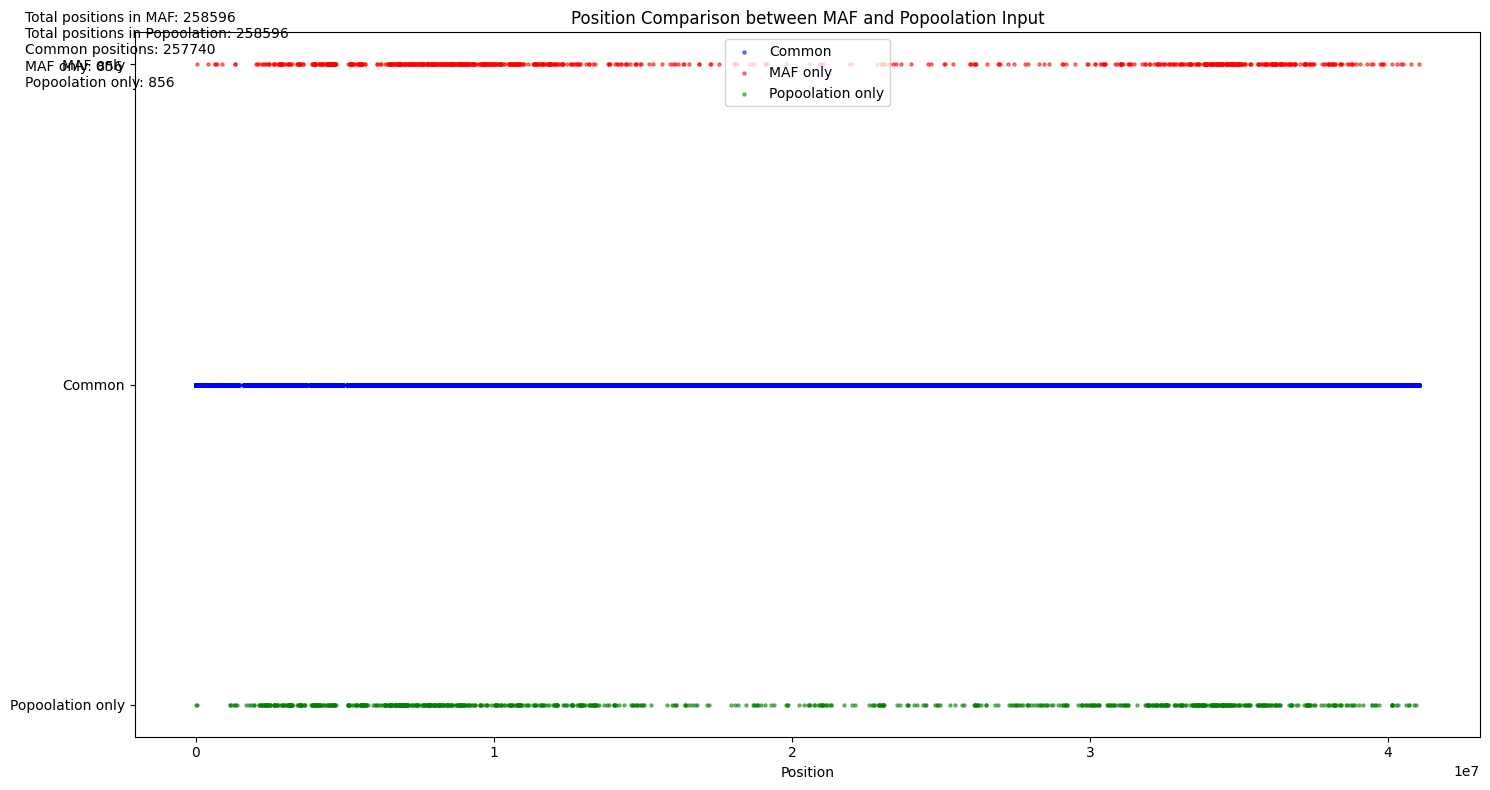

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load files
maf_df = pd.read_csv(r'C:/Users/mitsi/Desktop/seabream repo/data/processed_maf/maf_LR537121.csv')
pop_input = pd.read_csv(r'D:\seabream files\maf_LR537121_popoolation.txt', sep=' ', header=None)

# Get positions as sets for comparison
maf_positions = set(maf_df['pos'])
pop_input_positions = set(pop_input[1])

# Find positions unique to each file
in_maf_not_pop = maf_positions - pop_input_positions
in_pop_not_maf = pop_input_positions - maf_positions
common_positions = maf_positions & pop_input_positions

# Create arrays for plotting
maf_only_positions = np.array(list(in_maf_not_pop))
pop_only_positions = np.array(list(in_pop_not_maf))
common_pos = np.array(list(common_positions))

# Create the plot
plt.figure(figsize=(15, 8))

# Plot common positions
plt.scatter(common_pos, np.ones_like(common_pos), 
           alpha=0.5, label='Common', color='blue', s=5)

# Plot MAF-only positions
plt.scatter(maf_only_positions, np.ones_like(maf_only_positions) * 1.5, 
           alpha=0.5, label='MAF only', color='red', s=5)

# Plot Popoolation-only positions
plt.scatter(pop_only_positions, np.ones_like(pop_only_positions) * 0.5, 
           alpha=0.5, label='Popoolation only', color='green', s=5)

# Customize the plot
plt.yticks([0.5, 1, 1.5], ['Popoolation only', 'Common', 'MAF only'])
plt.xlabel('Position')
plt.title('Position Comparison between MAF and Popoolation Input')
plt.legend()

# Add summary text
plt.figtext(0.02, 0.98, 
            f'Total positions in MAF: {len(maf_positions)}\n' + 
            f'Total positions in Popoolation: {len(pop_input_positions)}\n' + 
            f'Common positions: {len(common_positions)}\n' + 
            f'MAF only: {len(in_maf_not_pop)}\n' + 
            f'Popoolation only: {len(in_pop_not_maf)}', 
            fontsize=10, va='top')

plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load files
maf_df = pd.read_csv(r'C:/Users/mitsi/Desktop/seabream repo/data/processed_maf/maf_LR537121.csv')
pop_input = pd.read_csv(r'D:\seabream files\maf_LR537121_popoolation.txt', sep=' ', header=None)

# Get positions as sets
maf_positions = set(maf_df['pos'])
pop_input_positions = set(pop_input[1])

# Find different categories of positions
common_positions = maf_positions & pop_input_positions
in_maf_not_pop = maf_positions - pop_input_positions
in_pop_not_maf = pop_input_positions - maf_positions

# Create DataFrame for plotting
plot_data = pd.DataFrame({
   'Position': list(common_positions) + list(in_maf_not_pop) + list(in_pop_not_maf),
   'Source': ['Common']*len(common_positions) + 
            ['MAF only']*len(in_maf_not_pop) + 
            ['Popoolation only']*len(in_pop_not_maf)
})

# Filter for positions between 20M and 23M
plot_data_filtered = plot_data[
   (plot_data['Position'] >= 20_000_000) & 
   (plot_data['Position'] <= 23_000_000)
]

# Set style and figure size
plt.style.use('seaborn')
plt.figure(figsize=(15, 8))

# Create scatter plot
sns.scatterplot(data=plot_data_filtered, 
               x='Position', 
               y='Source',
               hue='Source',
               palette={'Common': 'blue', 'MAF only': 'red', 'Popoolation only': 'green'},
               alpha=0.6,
               s=50)

# Customize plot
plt.title('Position Comparison (20M-23M range)')
plt.xlabel('Position')
plt.ylabel('Source')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Format x-axis to show millions
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_values])

# Add summary text for this region
region_summary = (
   f"Positions in range 20M-23M:\n"
   f"Common: {len(plot_data_filtered[plot_data_filtered['Source']=='Common'])}\n"
   f"MAF only: {len(plot_data_filtered[plot_data_filtered['Source']=='MAF only'])}\n"
   f"Popoolation only: {len(plot_data_filtered[plot_data_filtered['Source']=='Popoolation only'])}"
)
plt.figtext(0.02, 0.98, region_summary, fontsize=10, va='top')

plt.tight_layout()
plt.show()

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

## In order to keep the common rows from the two dataframes, we will be splitting both per chromosome

In [ ]:
import pandas as pd

# Split dataframes by chromosome
baypass_by_chr = dict(tuple(baypass_df.groupby('CHR')))
popoolation_by_chr = dict(tuple(popoolation_df.groupby('CHR')))

# Create mapping between chromosome formats (LR537121 -> 21)
chr_mapping = {chr_id: int(chr_id.replace('LR5371', '')) for chr_id in baypass_by_chr.keys()}

filtered_baypass = []
filtered_popoolation = []

print("\nDetailed Statistics per Chromosome:")
print("-" * 80)
print(f"{'Baypass Chr':<12} {'Pop Chr':<8} {'Baypass Rows':<12} {'Pop Rows':<12} {'Kept':<8} {'Removed':<8} {'% Kept':<8}")
print("-" * 80)

total_original_baypass = 0
total_original_pop = 0
total_kept = 0

# Process each chromosome
for bay_chr, bay_data in baypass_by_chr.items():
    pop_chr = chr_mapping[bay_chr]  # Get corresponding popoolation chromosome number
    
    # Skip if chromosome not in popoolation data
    if pop_chr not in popoolation_by_chr:
        print(f"{bay_chr:<12} {pop_chr:<8} {'N/A':<12} {'N/A':<12} {'N/A':<8} {'N/A':<8} {'N/A':<8}")
        continue
    
    pop_data = popoolation_by_chr[pop_chr]
    
    # Find common positions
    common_positions = set(bay_data['BP']) & set(pop_data['BP'])
    
    # Filter both dataframes
    bay_filtered = bay_data[bay_data['BP'].isin(common_positions)]
    pop_filtered = pop_data[pop_data['BP'].isin(common_positions)]
    
    # Filter both dataframes
    bay_removed = bay_data[~bay_data['BP'].isin(common_positions)]
    pop_removed = pop_data[~pop_data['BP'].isin(common_positions)]

    # Add to results
    filtered_baypass.append(bay_filtered)
    filtered_popoolation.append(pop_filtered)
    
    # Calculate statistics
    original_bay = len(bay_data)
    original_pop = len(pop_data)
    kept = len(common_positions)
    removed = original_bay - kept
    percent_kept = (kept / original_bay * 100) if original_bay > 0 else 0
    
    # Update totals
    total_original_baypass += original_bay
    total_original_pop += original_pop
    total_kept += kept
    
    # Print statistics
    print(f"{bay_chr:<12} {pop_chr:<8} {original_bay:<12} {original_pop:<12} {kept:<8} {removed:<8} {percent_kept:>6.1f}%")

# Print totals
print("-" * 80)
total_removed = total_original_baypass - total_kept
total_percent_kept = (total_kept / total_original_baypass * 100) if total_original_baypass > 0 else 0
print(f"{'TOTAL':<12} {'':<8} {total_original_baypass:<12} {total_original_pop:<12} {total_kept:<8} {total_removed:<8} {total_percent_kept:>6.1f}%")

# Combine filtered data
filtered_baypass_df = pd.concat(filtered_baypass)
filtered_popoolation_df = pd.concat(filtered_popoolation)

# Reset indices
filtered_baypass_df.reset_index(drop=True, inplace=True)
filtered_popoolation_df.reset_index(drop=True, inplace=True)

print(f"\nFinal filtered dataframes shape:")
print(f"Baypass: {filtered_baypass_df.shape}")
print(f"Popoolation: {filtered_popoolation_df.shape}")


Detailed Statistics per Chromosome:
--------------------------------------------------------------------------------
Baypass Chr  Pop Chr  Baypass Rows Pop Rows     Kept     Removed  % Kept  
--------------------------------------------------------------------------------
LR537121     21       258596       258596       257740   856        99.7%
LR537122     22       228223       228223       227528   695        99.7%
LR537123     23       236766       236766       236035   731        99.7%
LR537124     24       248369       248318       247501   868        99.7%
LR537125     25       208685       208685       207982   703        99.7%
LR537126     26       227765       227750       226952   813        99.6%
LR537127     27       217436       217434       216722   714        99.7%
LR537128     28       211632       211632       210929   703        99.7%
LR537129     29       223920       223920       223205   715        99.7%
LR537130     30       276258       276246       275419   839

In [32]:
filtered_popoolation_df

,CHR,BP,P_fet,colors
0,21,24,0.576,1
1,21,45,1.414,1
2,21,51,1.067,1
3,21,55,1.398,1
4,21,63,0.340,1
...,...,...,...,...
5282879,44,22260474,1.887,0
5282880,44,22260486,0.423,0
5282881,44,22260505,0.044,0
5282882,44,22260506,0.143,0


In [33]:
filtered_baypass_df

,CHR,BP,P,SNP,colors
0,LR537121,24,0.090135,1,1
1,LR537121,45,3.946796,2,1
2,LR537121,51,0.246870,3,1
3,LR537121,55,0.788874,4,1
4,LR537121,63,2.039485,5,1
...,...,...,...,...,...
5282879,LR537144,22260474,0.327995,174391,0
5282880,LR537144,22260486,4.993542,174392,0
5282881,LR537144,22260505,3.469923,174393,0
5282882,LR537144,22260506,2.176215,174394,0


Ignore the code below

In [84]:
maf_df = pd.read_csv('../../../data/processed_maf/maf_LR537121.csv')

In [85]:
maf_df

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,LR537121.1,24,2239057,a,458,0,0,33,765,0,...,0,39,315,0,0,38,127,0,0,16
1,LR537121.1,45,3459628,G,0,0,901,14,0,0,...,611,16,0,0,584,0,0,0,237,3
2,LR537121.1,51,3572428,G,48,0,976,0,86,0,...,642,0,59,0,603,0,12,0,255,0
3,LR537121.1,55,3722590,T,0,32,0,1064,0,23,...,0,735,0,13,0,714,0,9,0,286
4,LR537121.1,63,3881948,T,112,0,0,1168,143,0,...,0,750,63,0,0,787,25,0,0,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,LR537121.1,41028332,3330998,G,0,0,119,13,0,0,...,43,23,0,0,37,23,0,0,42,24
258592,LR537121.1,41028595,3331185,C,0,116,0,20,0,63,...,0,46,0,38,0,18,0,42,0,30
258593,LR537121.1,41028932,3331455,G,0,0,173,0,0,0,...,74,0,1,0,73,0,0,0,70,0
258594,LR537121.1,41029306,3331668,A,139,10,0,0,91,2,...,0,0,62,0,0,0,62,0,0,0


In [81]:
maf_df2 = pd.read_csv('../../../data/processed_maf/maf_LR537139.csv')

In [82]:
maf_df2

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,LR537139.1,165,4404174,G,0,0,251,0,0,0,...,223,0,0,14,207,0,0,0,98,0
1,LR537139.1,166,4451486,C,0,251,0,0,0,348,...,0,0,13,208,0,0,0,100,0,0
2,LR537139.1,175,4975311,G,20,0,236,0,22,0,...,230,0,20,0,213,0,3,0,100,0
3,LR537139.1,195,6041699,a,241,0,0,18,343,0,...,0,8,225,0,0,17,96,0,0,9
4,LR537139.1,196,6103515,g,0,19,240,0,0,78,...,248,0,0,13,229,0,0,4,103,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213677,LR537139.1,31047674,3536688,c,0,451,0,34,0,780,...,0,16,0,414,0,16,0,168,0,9
213678,LR537139.1,31047675,3536689,g,10,0,463,0,18,0,...,346,0,10,0,413,0,0,0,171,0
213679,LR537139.1,31047681,3536695,a,408,0,0,8,697,0,...,0,5,367,0,0,12,139,0,0,5
213680,LR537139.1,31047685,3536699,t,0,4,0,387,0,13,...,0,268,0,8,0,354,0,4,0,130


In [87]:
raw_maf1 = pd.read_csv('../../../data/raw_maf/maf_LR537121.csv')
raw_maf2 = pd.read_csv('../../../data/raw_maf/maf_LR537139.csv')

C:\Users\mitsi\AppData\Local\Temp\ipykernel_23760\3250191442.py:1: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_maf1 = pd.read_csv('../../../data/raw_maf/maf_LR537121.csv')
C:\Users\mitsi\AppData\Local\Temp\ipykernel_23760\3250191442.py:2: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_maf2 = pd.read_csv('../../../data/raw_maf/maf_LR537139.csv')


In [90]:
raw_maf = pd.read_csv('../../../data/raw_maf/maf_all.csv')
raw_maf

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,LR537130.1,1000350,5077754,T,0,138,0,28,0,111,...,0,5,0,75,0,5,0,36,0,25
1,LR537130.1,1000482,5077837,a,132,0,0,17,118,0,...,0,1,54,0,0,8,54,0,0,3
2,LR537130.1,1000875,5078138,c,3,135,0,0,6,136,...,0,0,9,76,0,0,0,63,0,0
3,LR537130.1,1000877,5078140,a,135,0,3,0,134,0,...,0,0,77,0,9,0,63,0,0,0
4,LR537130.1,1001501,5078440,a,145,0,0,0,141,0,...,0,0,70,0,0,0,70,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5318984,LR537129.1,9999908,5077394,C,5,149,0,0,0,137,...,0,0,0,75,0,0,0,74,0,0
5318985,LR537129.1,9999926,5077414,C,0,153,0,5,0,134,...,0,0,0,73,0,3,0,80,0,0
5318986,LR537129.1,9999967,5077450,G,0,0,29,128,0,0,...,4,56,0,0,5,62,0,0,10,62
5318987,LR537129.1,9999983,5077468,T,0,0,5,134,0,0,...,4,55,0,0,6,56,0,0,5,68


In [89]:
raw_maf2

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
1,LR537139.1,10001342,1131553,C,0,145,0,0,0,126,...,0,0,0,56,0,0,0,63,0,0
2,LR537139.1,10001641,1131734,g,0,0,172,0,0,0,...,87,0,0,6,67,0,0,5,76,0
3,LR537139.1,10001675,1131768,C,0,166,0,5,0,151,...,0,0,0,79,0,4,0,90,0,0
4,LR537139.1,10001686,1131779,G,3,0,165,0,17,0,...,61,0,12,0,65,0,11,0,79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214412,LR537139.1,9998391,6824995,G,0,0,108,36,0,0,...,47,28,0,0,43,16,0,0,46,9
214413,LR537139.1,9998399,6825002,C,0,143,0,0,6,149,...,0,0,0,65,0,0,0,59,0,0
214414,LR537139.1,9998413,6825019,C,0,85,0,63,0,61,...,0,30,0,39,0,23,0,26,0,29
214415,LR537139.1,9998577,6825123,G,9,0,124,0,4,0,...,51,0,8,0,48,0,5,0,50,0


In [91]:
raw_maf1

,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
0,chr,pos,index,ref_n,A,C,G,T,A.1,C.1,...,G.17,T.17,A.18,C.18,G.18,T.18,A.19,C.19,G.19,T.19
1,LR537121.1,10000758,109,A,69,73,0,0,81,56,...,0,0,28,32,0,0,24,37,0,0
2,LR537121.1,10000810,161,G,0,0,130,2,0,0,...,54,1,0,0,55,0,0,0,58,0
3,LR537121.1,10001732,414,T,0,0,0,97,0,0,...,0,70,0,0,1,58,0,0,4,53
4,LR537121.1,10002181,488,C,0,73,0,87,0,90,...,0,41,0,43,0,38,0,28,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259454,LR537121.1,9999603,5234219,G,0,0,150,0,4,0,...,61,0,2,0,65,0,0,0,59,0
259455,LR537121.1,9999619,5234235,T,0,2,0,146,0,0,...,0,56,0,0,0,67,0,0,0,62
259456,LR537121.1,9999843,5234276,C,2,151,0,0,0,83,...,0,0,0,65,0,0,1,54,0,0
259457,LR537121.1,9999892,5234319,A,136,0,0,0,100,0,...,0,0,58,0,0,0,58,0,0,10


In [37]:
popoolation_df

,Unnamed: 0,CHR,BP,P_fet,i,colors
0,0,21,24,0.576,0,1
1,1,21,45,1.414,1,1
2,2,21,51,1.067,2,1
3,3,21,55,1.398,3,1
4,4,21,63,0.340,4,1
...,...,...,...,...,...,...
5300770,5300770,44,22260474,1.887,5300770,0
5300771,5300771,44,22260486,0.423,5300771,0
5300772,5300772,44,22260505,0.044,5300772,0
5300773,5300773,44,22260506,0.143,5300773,0


In [38]:
baypass_df

,CHR,BP,P,SNP,i,colors
0,LR537121,24,0.090135,1,0,1
1,LR537121,45,3.946796,2,1,1
2,LR537121,51,0.246870,3,2,1
3,LR537121,55,0.788874,4,3,1
4,LR537121,63,2.039485,5,4,1
...,...,...,...,...,...,...
5300851,LR537144,22260474,0.327995,174391,5300851,0
5300852,LR537144,22260486,4.993542,174392,5300852,0
5300853,LR537144,22260505,3.469923,174393,5300853,0
5300854,LR537144,22260506,2.176215,174394,5300854,0


In [68]:
# first remove the extra rows from the Baypass dataset based on the 'BP' column
filtered_baypass_df = baypass_df[baypass_df['BP'].isin(popoolation_df['BP'])]
filtered_popoolation_df = popoolation_df[popoolation_df['BP'].isin(baypass_df['BP'])]
# filtered_popoolation_df = popoolation_df[baypass_df['BP'].isin(popoolation_df['BP'])]

In [69]:
# do the same for baypass_df
# filtered_baypass_df = baypass_df[baypass_df['BP'].isin(popoolation_df['BP'])]
filtered_baypass_df = filtered_baypass_df[filtered_popoolation_df['BP'].isin(filtered_baypass_df['BP'])]
filtered_popoolation_df = filtered_popoolation_df[filtered_baypass_df['BP'].isin(filtered_popoolation_df['BP'])]

C:\Users\mitsi\AppData\Local\Temp\ipykernel_23760\3039803155.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_baypass_df = filtered_baypass_df[filtered_popoolation_df['BP'].isin(filtered_baypass_df['BP'])]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [70]:
# Assuming your dataframes are called df1 and df2
merged_df = pd.merge(popoolation_df, baypass_df,  # DataFrames to merge
                    on='BP',        # Column to merge on
                    how='inner')    # Only keep matching rows

In [72]:
import pandas as pd

# Get common BP values between both dataframes
common_bps = set(popoolation_df['BP']).intersection(set(baypass_df['BP']))

# Filter each dataframe to keep only rows with common BP values
popoolation_filtered = popoolation_df[popoolation_df['BP'].isin(common_bps)]
baypass_filtered = baypass_df[baypass_df['BP'].isin(common_bps)]

In [73]:
# Print the shapes before and after filtering
print(f"Popoolation shape before: {popoolation_df.shape}")
print(f"Popoolation shape after: {popoolation_filtered.shape}")
print(f"Baypass shape before: {baypass_df.shape}")
print(f"Baypass shape after: {baypass_filtered.shape}")

Popoolation shape before: (5300775, 6)
Popoolation shape after: (5285406, 6)
Baypass shape before: (5300856, 6)
Baypass shape after: (5285509, 6)


In [74]:
# Check for duplicate BP values in each filtered dataframe
print("Duplicate BP counts:")
print(f"Popoolation duplicates: {popoolation_filtered['BP'].duplicated().sum()}")
print(f"Baypass duplicates: {baypass_filtered['BP'].duplicated().sum()}")

# Get a few examples of duplicated BPs if they exist
print("\nExample of duplicated BPs in Popoolation:")
print(popoolation_filtered[popoolation_filtered['BP'].duplicated(keep=False)].head())
print("\nExample of duplicated BPs in Baypass:")
print(baypass_filtered[baypass_filtered['BP'].duplicated(keep=False)].head())

Duplicate BP counts:
Popoolation duplicates: 375773
Baypass duplicates: 375876

Example of duplicated BPs in Popoolation:
    Unnamed: 0  CHR   BP  P_fet   i  colors
21          21   21  165  1.100  21       1
28          28   21  182  0.628  28       1
31          31   21  213  0.291  31       1
43          43   21  412  0.952  43       1
45          45   21  423  0.190  45       1

Example of duplicated BPs in Baypass:
         CHR   BP         P  SNP   i  colors
21  LR537121  165  3.918954   22  21       1
28  LR537121  182  0.624683   29  28       1
31  LR537121  213  3.402453   32  31       1
43  LR537121  412  0.102813   44  43       1
45  LR537121  423  1.586943   46  45       1


In [75]:
# Let's look at the complete structure of duplicates for one specific BP value
print("Detailed look at BP=165 in Popoolation:")
print(popoolation_filtered[popoolation_filtered['BP'] == 165])
print("\nDetailed look at BP=165 in Baypass:")
print(baypass_filtered[baypass_filtered['BP'] == 165])

# Let's also check the distribution of duplicate counts
print("\nNumber of occurrences per BP in Popoolation:")
print(popoolation_filtered['BP'].value_counts().value_counts())
print("\nNumber of occurrences per BP in Baypass:")
print(baypass_filtered['BP'].value_counts().value_counts())

Detailed look at BP=165 in Popoolation:
         Unnamed: 0  CHR   BP  P_fet        i  colors
21               21   21  165  1.100       21       1
4093881     4093881   39  165  1.245  4093881       1

Detailed look at BP=165 in Baypass:
              CHR   BP         P  SNP        i  colors
21       LR537121  165  3.918954   22       21       1
4093961  LR537139  165  0.184545    1  4093961       1

Number of occurrences per BP in Popoolation:
count
1    4553268
2     337701
3      17945
4        696
5         21
6          2
Name: count, dtype: int64

Number of occurrences per BP in Baypass:
count
1    4553174
2     337781
3      17964
4        691
5         21
6          2
Name: count, dtype: int64


In [76]:
# Create a composite key using both CHR and BP
popoolation_df['chr_bp'] = popoolation_df['CHR'].astype(str) + '_' + popoolation_df['BP'].astype(str)
baypass_df['chr_bp'] = baypass_df['CHR'].astype(str) + '_' + baypass_df['BP'].astype(str)

# Get common chr_bp combinations
common_chr_bp = set(popoolation_df['chr_bp']).intersection(set(baypass_df['chr_bp']))

# Filter dataframes based on common chr_bp
popoolation_filtered = popoolation_df[popoolation_df['chr_bp'].isin(common_chr_bp)]
baypass_filtered = baypass_df[baypass_df['chr_bp'].isin(common_chr_bp)]

# Remove the temporary chr_bp column
popoolation_filtered = popoolation_filtered.drop('chr_bp', axis=1)
baypass_filtered = baypass_filtered.drop('chr_bp', axis=1)

# Check new shapes
print(f"Popoolation shape after chr-bp filtering: {popoolation_filtered.shape}")
print(f"Baypass shape after chr-bp filtering: {baypass_filtered.shape}")

Popoolation shape after chr-bp filtering: (0, 6)
Baypass shape after chr-bp filtering: (0, 6)


In [64]:
filtered_popoolation_df

,Unnamed: 0,CHR,BP,P_fet,i,colors
0,0,21,24,0.576,0,1
1,1,21,45,1.414,1,1
2,2,21,51,1.067,2,1
3,3,21,55,1.398,3,1
4,4,21,63,0.340,4,1
...,...,...,...,...,...,...
5300770,5300770,44,22260474,1.887,5300770,0
5300771,5300771,44,22260486,0.423,5300771,0
5300772,5300772,44,22260505,0.044,5300772,0
5300773,5300773,44,22260506,0.143,5300773,0


In [40]:
filtered_baypass_df = baypass_df[baypass_df['BP'].isin(popoolation_df['BP'])]

In [43]:
filtered_popoolation_df

,Unnamed: 0,CHR,BP,P_fet,i,colors
0,0,21,24,0.576,0,1
1,1,21,45,1.414,1,1
2,2,21,51,1.067,2,1
3,3,21,55,1.398,3,1
4,4,21,63,0.340,4,1
...,...,...,...,...,...,...
5300770,5300770,44,22260474,1.887,5300770,0
5300771,5300771,44,22260486,0.423,5300771,0
5300772,5300772,44,22260505,0.044,5300772,0
5300773,5300773,44,22260506,0.143,5300773,0


In [62]:
len(filtered_baypass_df)

5285509

In [46]:
# check if the two datasets have the same number of rows\
print(filtered_popoolation_df.shape)
print(filtered_baypass_df.shape)


(5285406, 6)
(5285509, 6)


In [ ]:
# There is a difference in the number of rows between the two datasets
# This is because the two datasets have different number of rows
# We can merge the two datasets using the 'BP' column
# but first we need to check why the two datasets have different number of rows
# as we already removed the extra rows from the Baypass dataset based on the BP column
# as well as the extra rows from the Popoolation dataset based on the BP column
# We can check if the two datasets have the same values in the 'BP' column
# If they do, then we can merge the two datasets using the 'BP' column
# If they don't, then we need to check why the two datasets have different values in the 'BP' column
# and then decide how to merge the two
# code start:
# Check if the two datasets have the same values in the 'BP' column
popoolation_BP_values = set(filtered_popoolation_df['BP'])
baypass_BP_values = set(filtered_baypass_df['BP'])
print(popoolation_BP_values)
print(baypass_BP_values)


In [60]:
print(filtered_popoolation_df['BP'].isin(filtered_baypass_df['BP']))

0          True
1          True
2          True
3          True
4          True
           ... 
5300770    True
5300771    True
5300772    True
5300773    True
5300774    True
Name: BP, Length: 5285406, dtype: bool


In [54]:
print(popoolation_BP_values == baypass_BP_values)

True


In [25]:
# get a list of the uncommon BP values
uncommon_BP_values = list(set(popoolation_df['BP']) - set(baypass_df['BP']))

In [28]:
len(uncommon_BP_values)

15364

In [30]:
# Find the reason we have different number of rows in the two datasets
# print(len(popoolation_df))
# print(len(baypass_df))
# print(len(filtered_popoolation_df))
# print(len(filtered_baypass_df))
# print(len(uncommon_BP_values))
# why do we have different number of rows in the two datasets? Explore why the rows where there is a mismatch in the BP and i values are not the same
print(popoolation_df[~popoolation_df['BP'].isin(baypass_df['BP'])])
print(baypass_df[~baypass_df['BP'].isin(popoolation_df['BP'])])

         Unnamed: 0  CHR        BP  P_fet        i  colors
138             138   21     13317  0.851      138       1
230             230   21     26628  0.143      230       1
2194           2194   21   1132220  1.159     2194       1
2281           2281   21   1143165  0.008     2281       1
3476           3476   21   1381822  0.890     3476       1
...             ...  ...       ...    ...      ...     ...
5298465     5298465   44  21593412  0.346  5298465       0
5298903     5298903   44  21776389  0.826  5298903       0
5299196     5299196   44  21861526  0.103  5299196       0
5299842     5299842   44  21998598  1.798  5299842       0
5300009     5300009   44  22024866  0.299  5300009       0

[15369 rows x 6 columns]
              CHR        BP         P     SNP        i  colors
331      LR537121     46258  0.603430     332      331       1
1013     LR537121    406730  0.308039    1014     1013       1
1484     LR537121    709910  0.885366    1485     1484       1
1559     LR537